# LSST CCOB ghost : misaligned optic tests

Study effect of misaligments on ghost images

## TODO
- move functions to library
- separate batoid module from analysis 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import matplotlib.pyplot as plt
import pandas as pd
import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import make_data_frame, compute_ghost_separations

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1
from ghosts.geom_config import GEOM_CONFIG_0

In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


In [4]:
from ghosts.beam import get_n_phot_for_power_nw_wl_nm

wl = 500  # nm
p = 100   # nW 
print(f'Number of photon for {p} nW at {wl} nm is {get_n_phot_for_power_nw_wl_nm(p, wl):e}')

Number of photon for 100 nW at 500 nm is 2.517058e+11


In [5]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

In [6]:
# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'Filter', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective

# Call on current telescope
tweak_optics.make_optics_reflective(telescope)


0

Direct path is number 28
  central impact point is (0.000030, 0.000002)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 843.6138


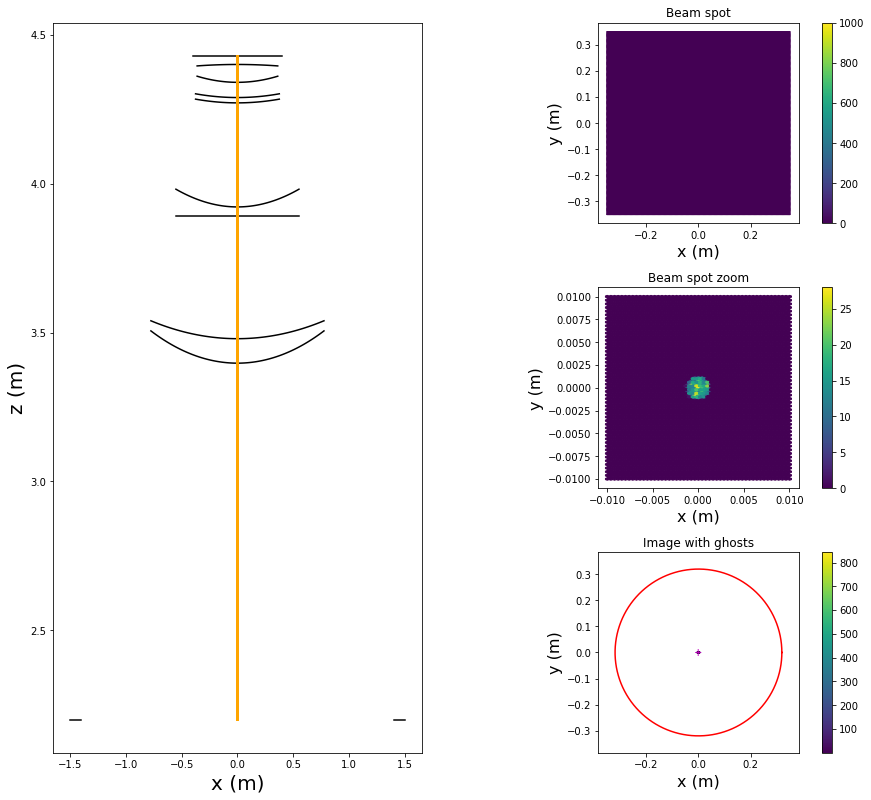

0

In [7]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_0)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)


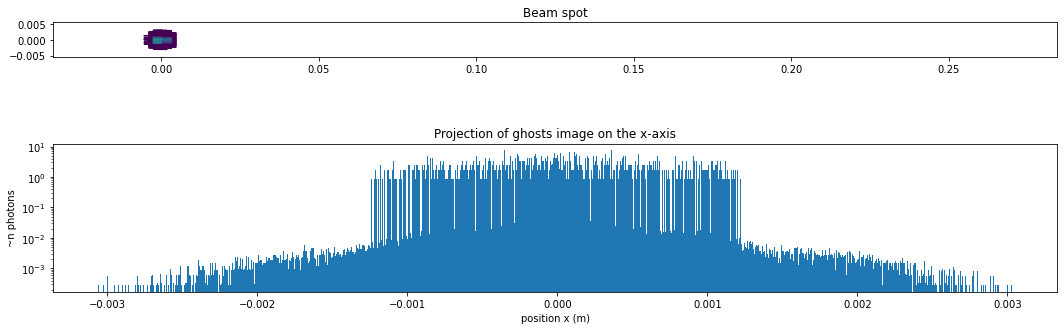

0

In [8]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


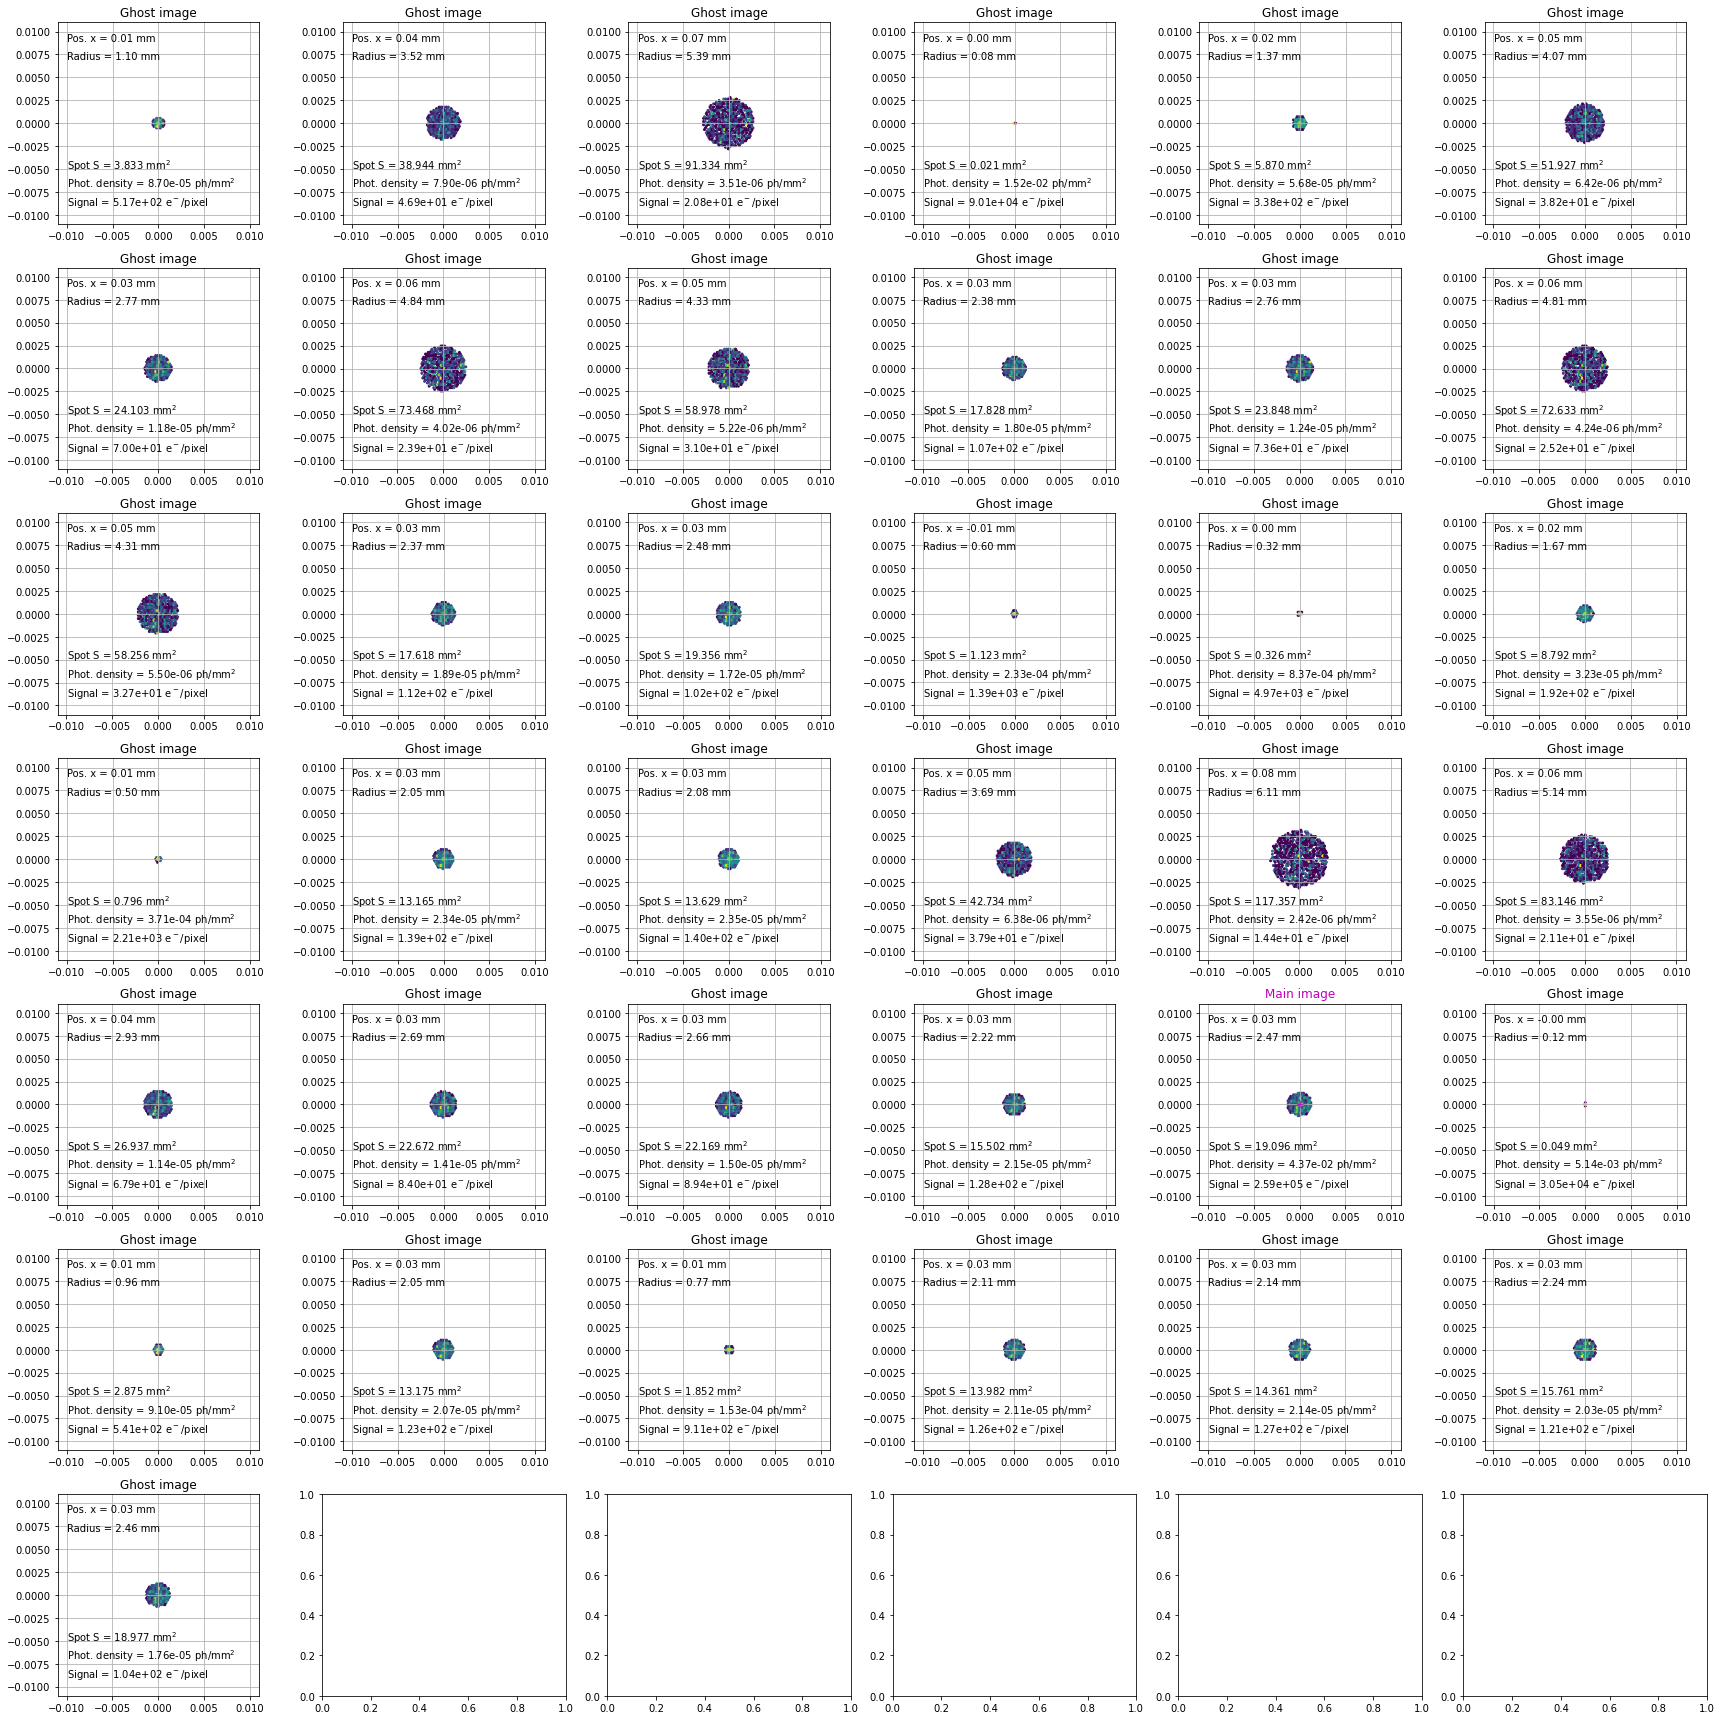

In [9]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(rForward)

In [10]:
data_frame_1 = make_data_frame(spots_data, BEAM_CONFIG_0['beam_id'], GEOM_CONFIG_0['geom_id'])
data_frame_1.sort_values(by=['name'])

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
33,0,0,33,"(Detector, Filter_entrance)",0.000026,0.000519,1.409125e-06,0.000519,0.002101,0.002119,0.002110,8.922367e-06,0.295428,13.981540,125.575758
34,0,0,34,"(Detector, Filter_exit)",0.000026,0.000526,1.428102e-06,0.000526,0.002129,0.002147,0.002138,9.042531e-06,0.307609,14.360676,127.301578
29,0,0,29,"(Detector, L1_entrance)",-0.000002,0.000031,-8.337210e-08,0.000031,0.000124,0.000125,0.000125,5.278932e-07,0.251339,0.048942,30520.279829
30,0,0,30,"(Detector, L1_exit)",0.000012,0.000235,6.389674e-07,0.000235,0.000953,0.000961,0.000957,4.045849e-06,0.261702,2.874844,541.007044
31,0,0,31,"(Detector, L2_entrance)",0.000025,0.000504,1.367862e-06,0.000504,0.002039,0.002056,0.002048,8.661099e-06,0.272493,13.174707,122.920459
32,0,0,32,"(Detector, L2_exit)",0.000009,0.000189,5.128351e-07,0.000189,0.000765,0.000771,0.000768,3.247198e-06,0.283729,1.851880,910.542299
35,0,0,35,"(Detector, L3_entrance)",0.000028,0.000551,1.496109e-06,0.000551,0.002230,0.002249,0.002240,9.473135e-06,0.320293,15.760939,120.774273
36,0,0,36,"(Detector, L3_exit)",0.000030,0.000604,1.641650e-06,0.000604,0.002447,0.002468,0.002458,1.039468e-05,0.333499,18.976542,104.444911
10,0,0,10,"(Filter_entrance, L1_entrance)",0.000034,0.000678,1.840326e-06,0.000678,0.002744,0.002767,0.002755,1.165267e-05,0.295428,23.847637,73.623331
11,0,0,11,"(Filter_entrance, L1_exit)",0.000059,0.001183,3.211723e-06,0.001183,0.004788,0.004829,0.004808,2.033615e-05,0.307609,72.632706,25.169608


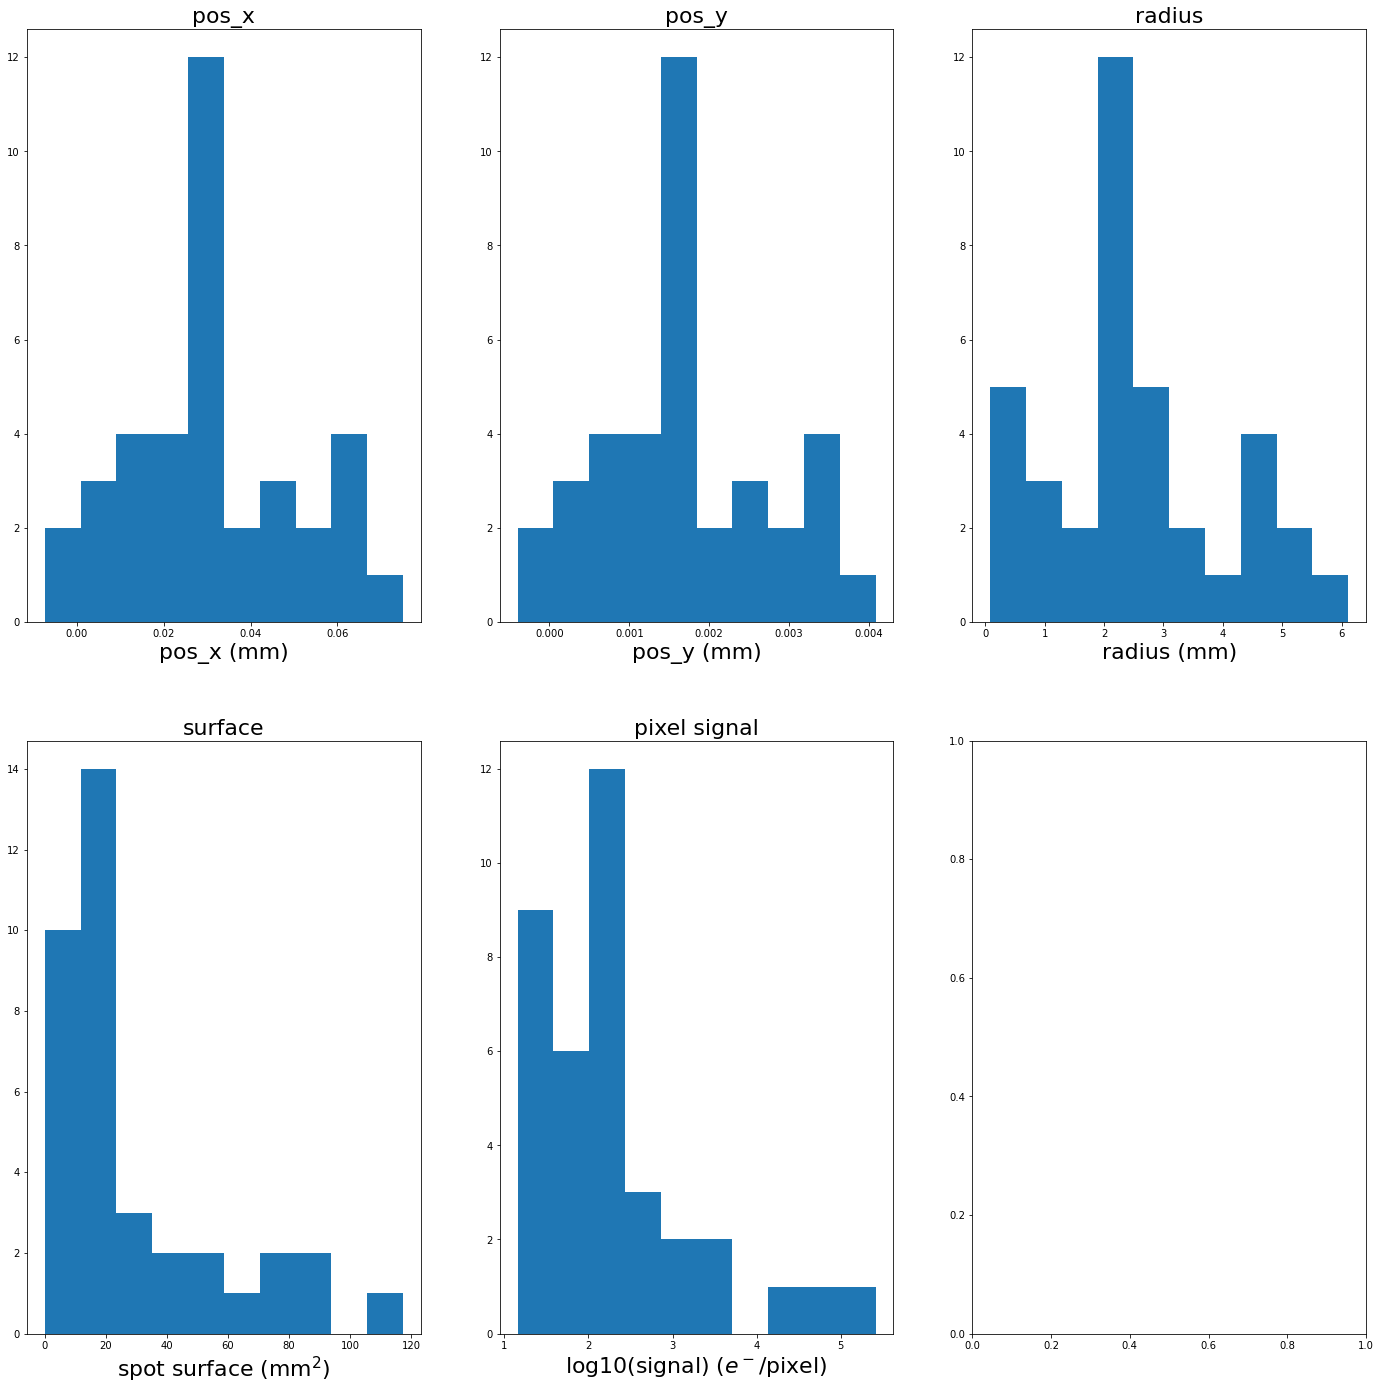

In [11]:
# Looking at overal spots stats
plotter.plot_spots_stats(data_frame_1)
plt.show()

In [12]:
#  compute ghost separations
ghost_separations = compute_ghost_separations(data_frame_1)
ghost_separations[100:105]

,ghost_1,ghost_2,name_1,name_2,distance,overlap,flux_ratio,surface_ratio,signal_ratio
100,2,34,"(L2_exit, L1_exit)","(Detector, Filter_exit)",0.000040,-0.007490,0.960400,0.157232,6.108157
101,2,35,"(L2_exit, L1_exit)","(Detector, L3_entrance)",0.000039,-0.007593,1.000000,0.172564,5.794965
102,3,4,"(L2_entrance, L1_entrance)","(L2_entrance, L1_exit)",0.000016,-0.001433,1.041233,277.839035,0.003748
103,3,5,"(L2_entrance, L1_entrance)","(L2_exit, L2_entrance)",0.000049,-0.004099,1.041233,2457.646744,0.000424
104,3,6,"(L2_entrance, L1_entrance)","(Filter_exit, L1_entrance)",0.000033,-0.002819,0.885842,1140.793266,0.000777


630 ghost spots pairs are in overlap out of 630


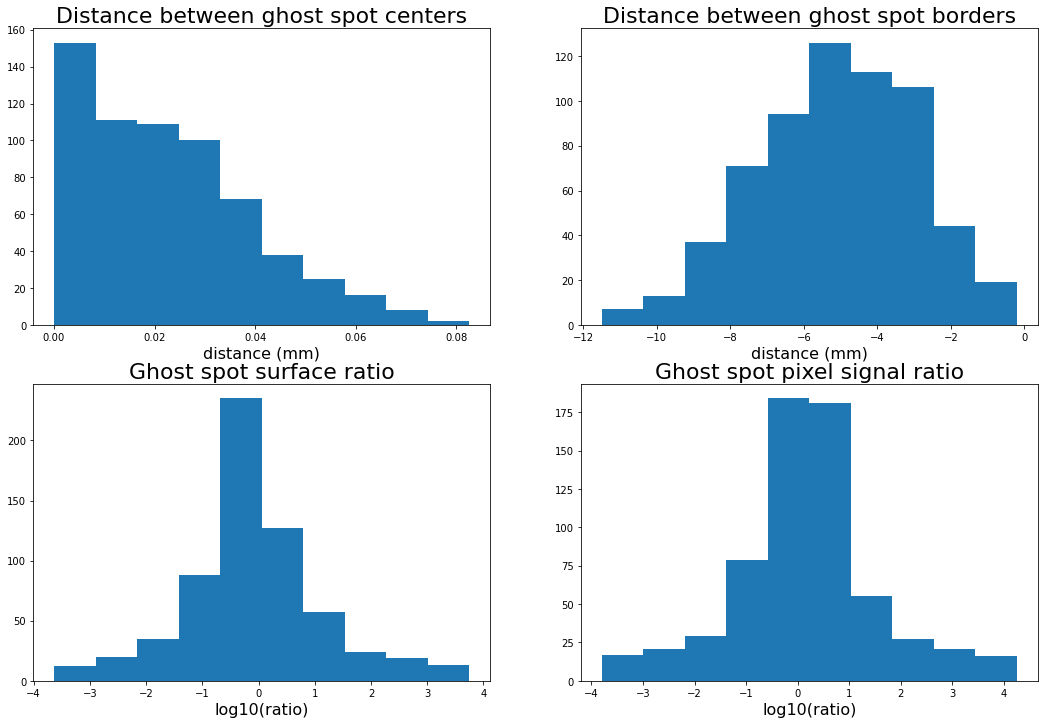

In [13]:
plotter.plot_ghosts_spots_distances(ghost_separations)
plt.show()


# Now rotating optics: L2

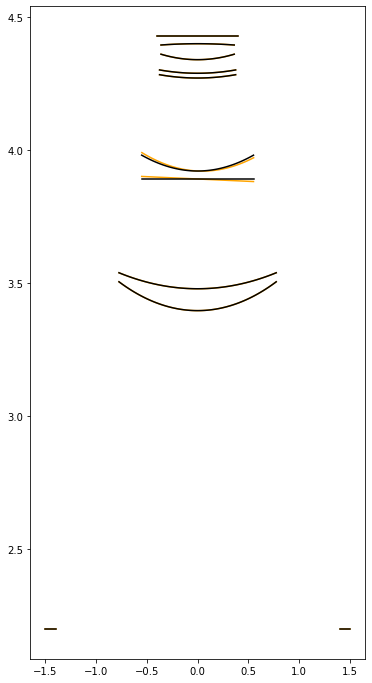

In [14]:
# Rotating L2 around Y
rotated_telescope = tweak_optics.rotate_optic(telescope, 'L2', axis='y', angle=1)
tweak_optics.make_optics_reflective(rotated_telescope)
# showing telescope
plt.rcParams["figure.figsize"] = [6, 12]
fig, ax = plt.subplots(1)
# after rotation
rotated_telescope.draw2d(ax, c='orange')
# before rotation
telescope.draw2d(ax, c='k')
plt.show()

Direct path is number 28
  central impact point is (0.000173, -0.000023)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 839.8114


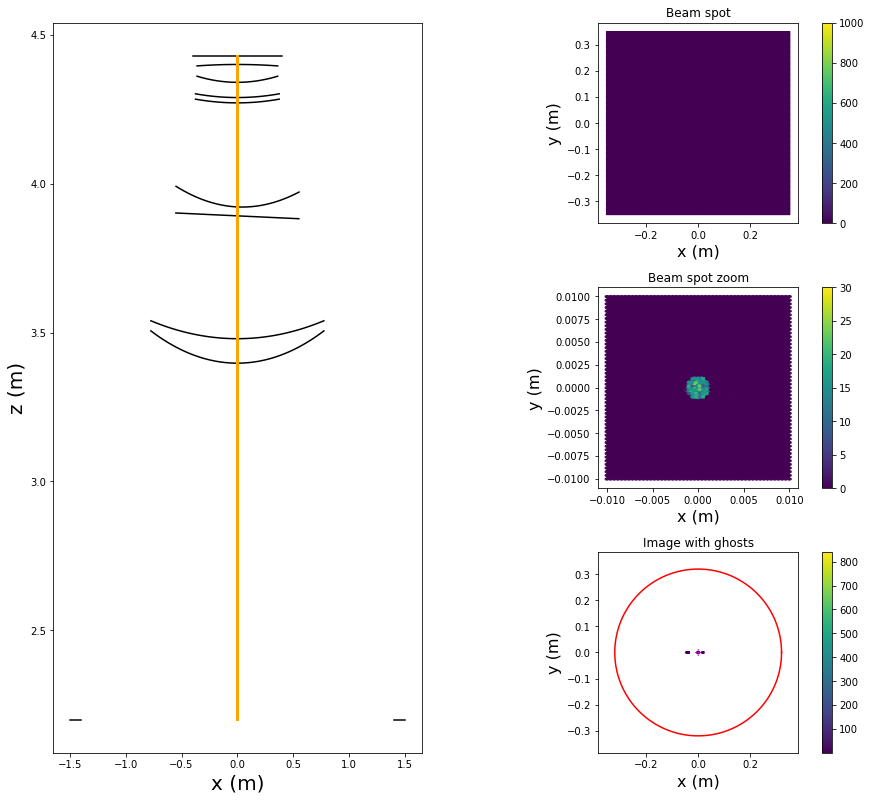

0

In [15]:
# Run simulation with standard beam config
traceFull_r, rForward_r, rReverse_r, rays_r = simulator.run_simulation(rotated_telescope, beam_config=BEAM_CONFIG_0)
simulation_r = [traceFull_r, rForward_r, rReverse_r, rays_r]
# Check setup
plotter.plot_setup(rotated_telescope, simulation_r)


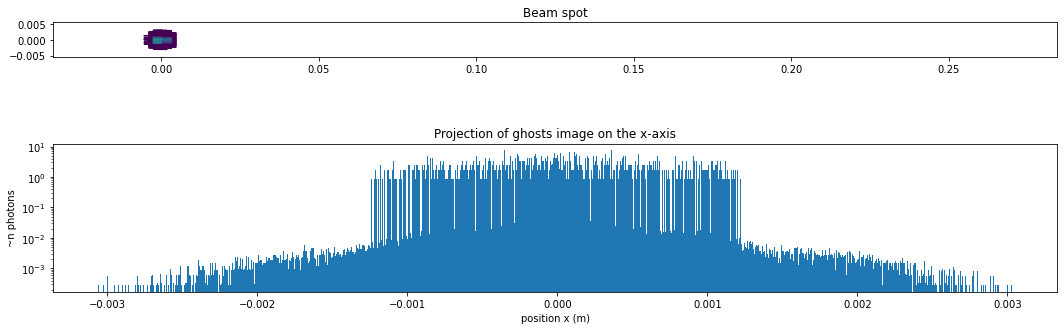

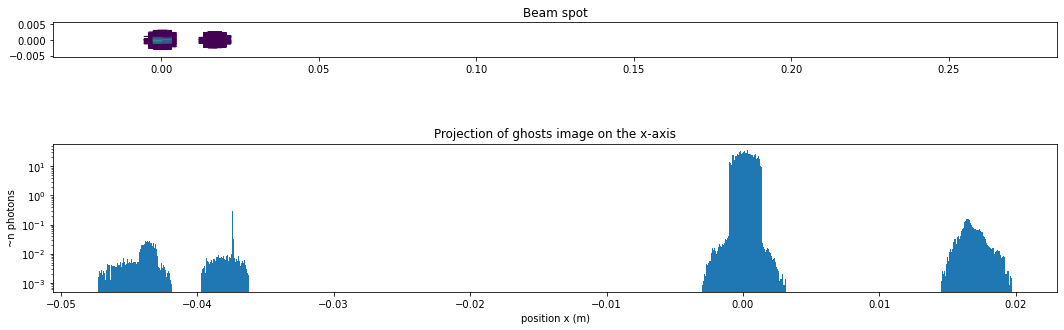

0

In [16]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)
plotter.plot_zoom_on_ghosts(rForward_r)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


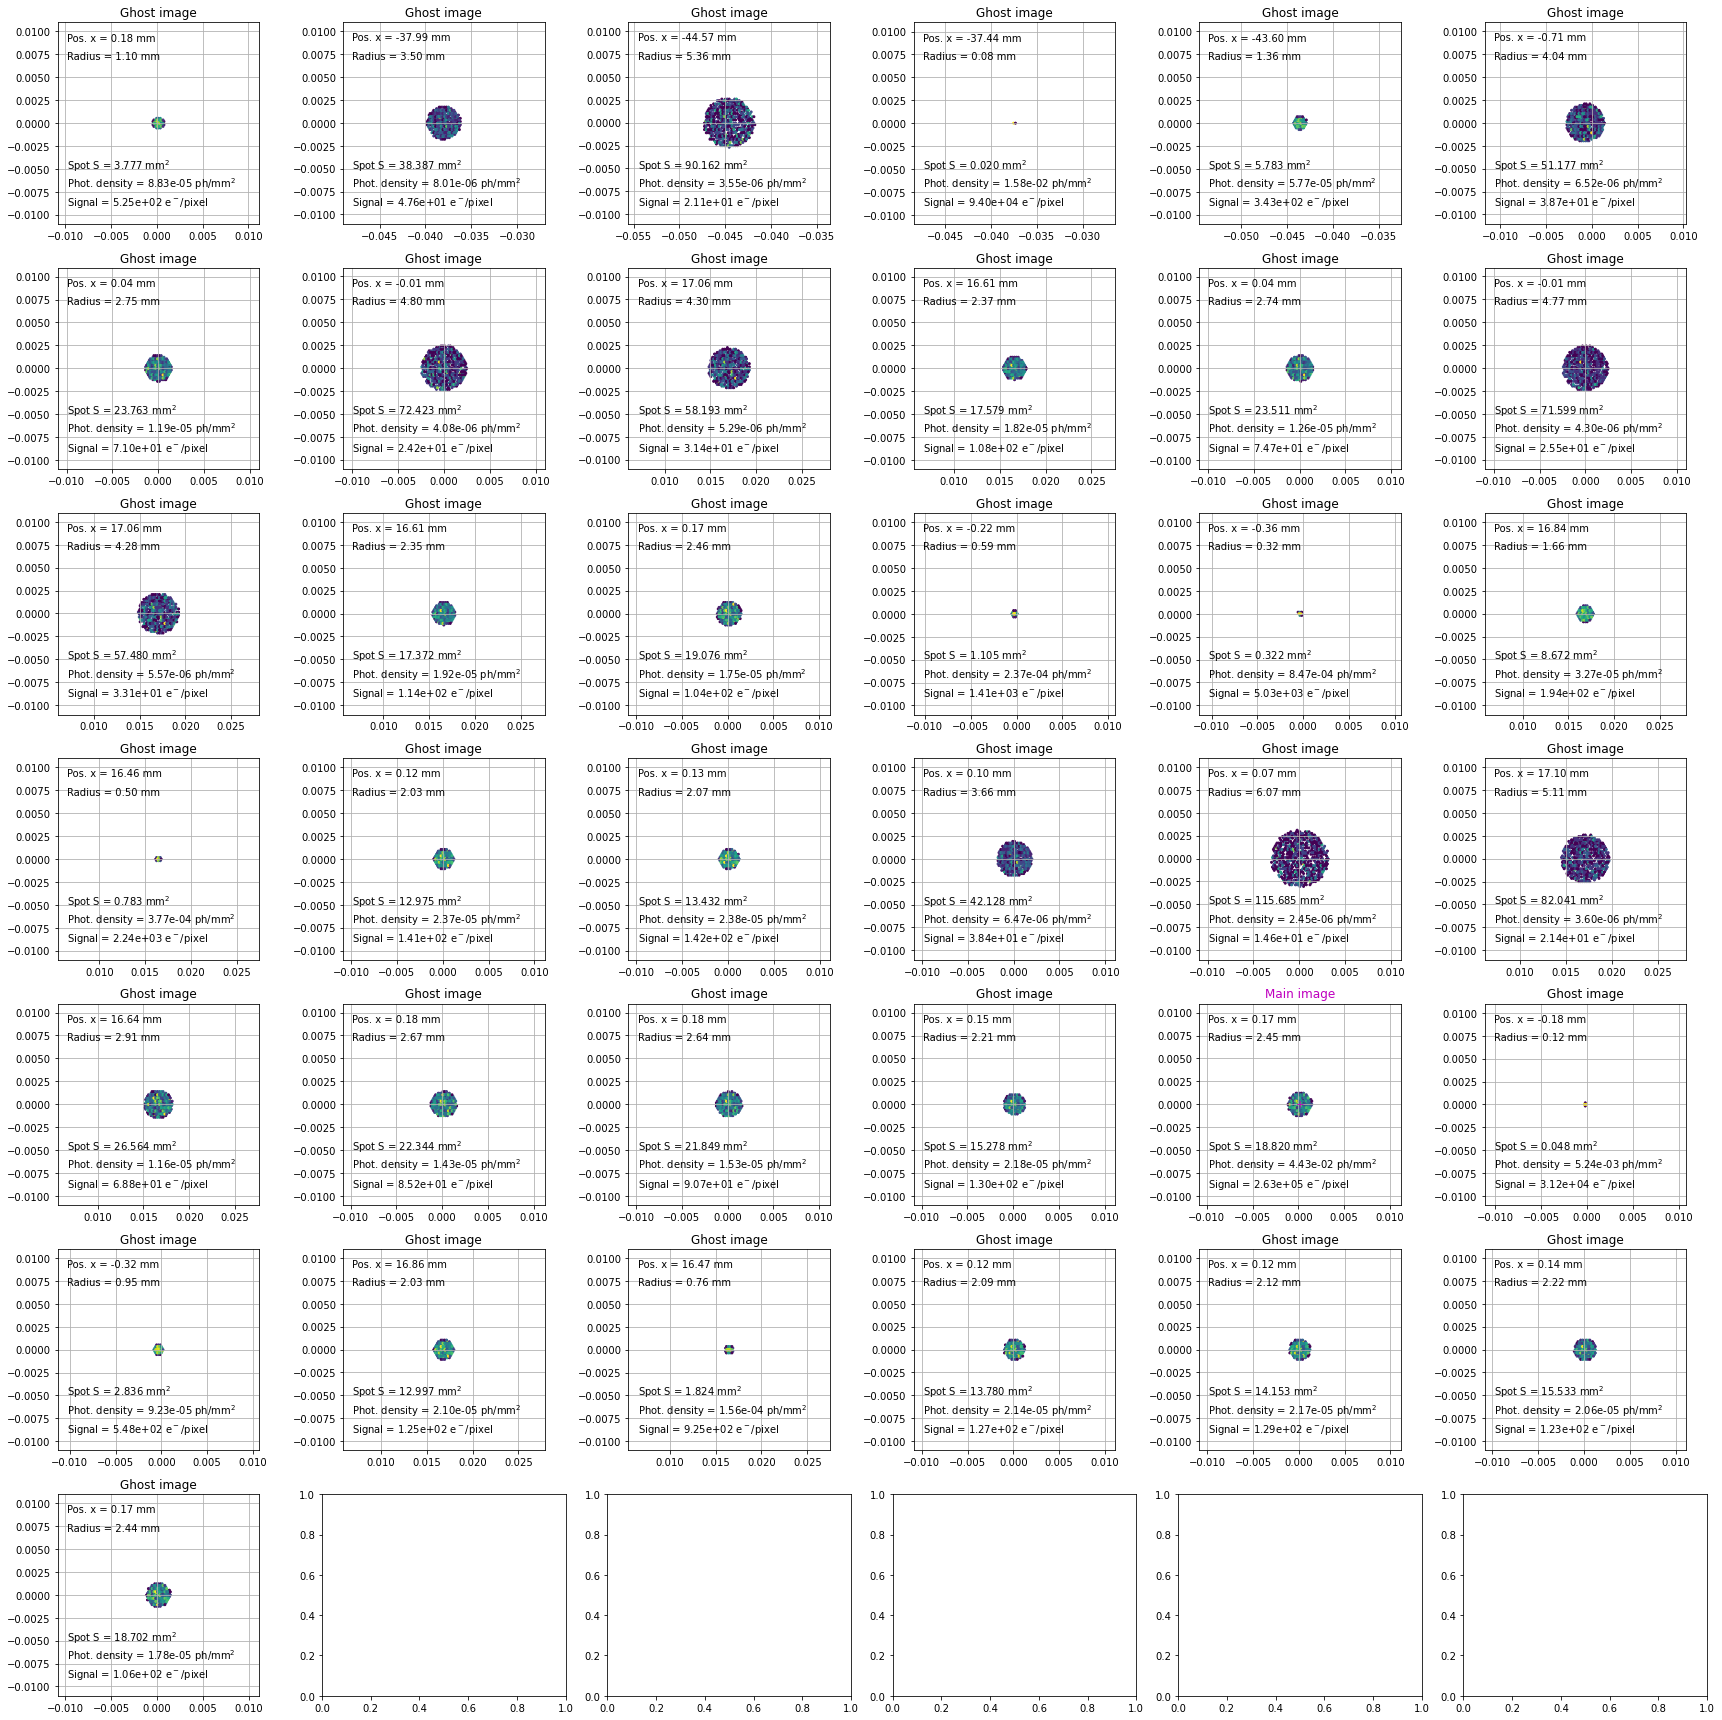

In [17]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data_r = plotter.plot_ghosts_map(rForward_r)

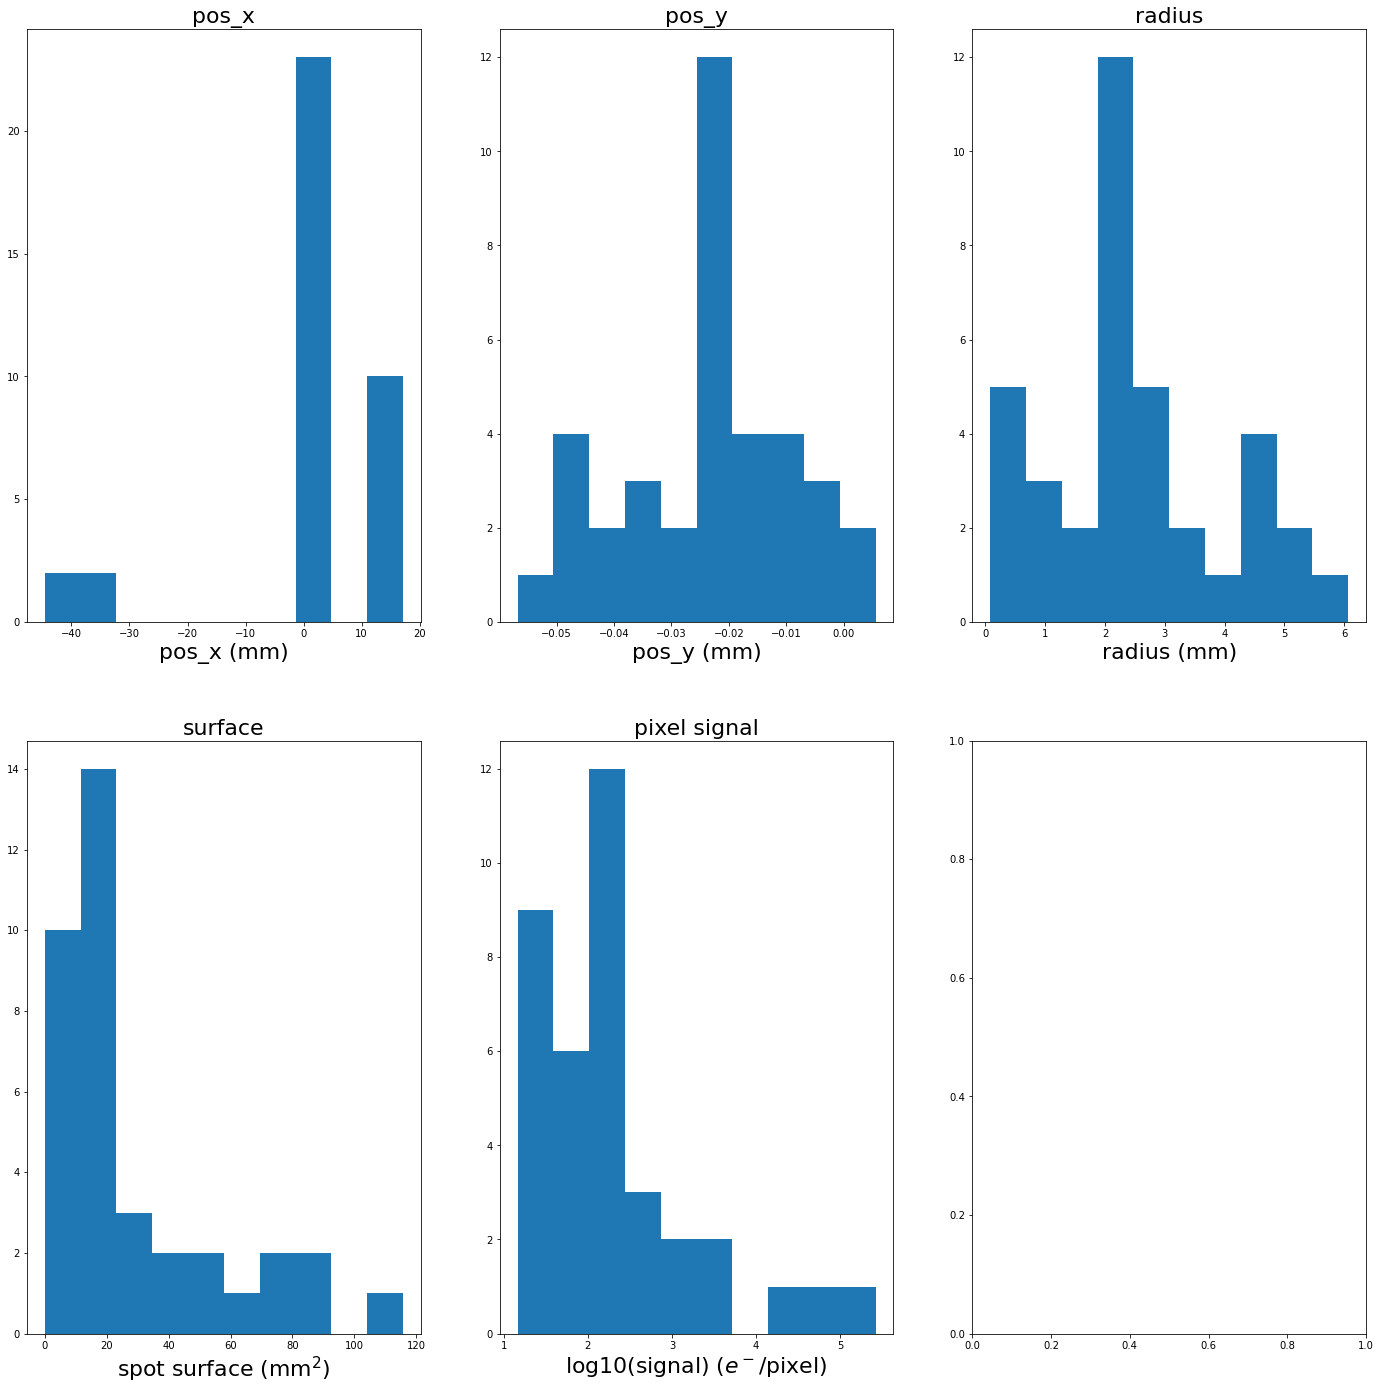

In [18]:
data_frame_r = make_data_frame(spots_data_r)
plotter.plot_spots_stats(data_frame_r)
plt.show()


279 ghost spots pairs are in overlap out of 630


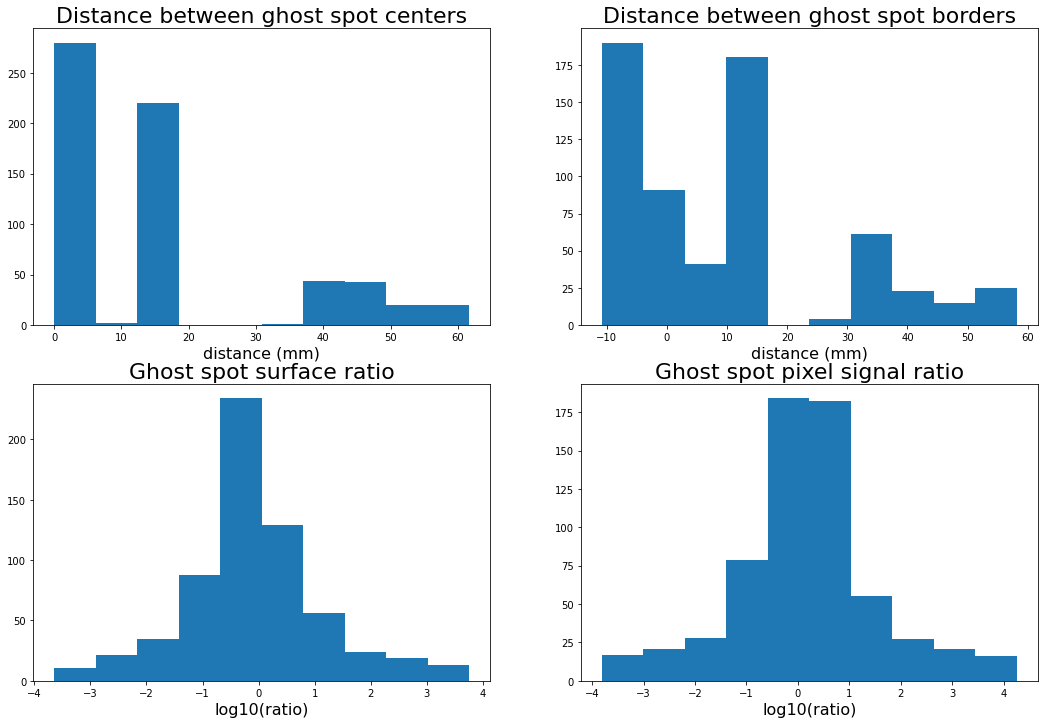

In [19]:
ghost_separations_r = compute_ghost_separations(data_frame_r)
plotter.plot_ghosts_spots_distances(ghost_separations_r)
plt.show()


In [20]:
ghost_separations[:10].sort_values(by=['name_1', 'name_2'])



,ghost_1,ghost_2,name_1,name_2,distance,overlap,flux_ratio,surface_ratio,signal_ratio
9,0,10,"(L1_exit, L1_entrance)","(Filter_entrance, L1_entrance)",0.000020,-0.003839,0.885842,6.221948,0.142374
5,0,6,"(L1_exit, L1_entrance)","(Filter_exit, L1_entrance)",0.000020,-0.003854,0.850763,6.288694,0.135285
6,0,7,"(L1_exit, L1_entrance)","(Filter_exit, L1_exit)",0.000046,-0.005895,0.885842,19.168232,0.046214
7,0,8,"(L1_exit, L1_entrance)","(Filter_exit, L2_entrance)",0.000040,-0.005398,0.922368,15.387598,0.059942
8,0,9,"(L1_exit, L1_entrance)","(Filter_exit, L2_exit)",0.000016,-0.003471,0.960400,4.651402,0.206475
2,0,3,"(L1_exit, L1_entrance)","(L2_entrance, L1_entrance)",0.000013,-0.001174,0.960400,0.005513,174.220240
3,0,4,"(L1_exit, L1_entrance)","(L2_entrance, L1_exit)",0.000003,-0.002468,1.000000,1.531605,0.652910
0,0,1,"(L1_exit, L1_entrance)","(L2_exit, L1_entrance)",0.000030,-0.004596,0.922368,10.160581,0.090779
1,0,2,"(L1_exit, L1_entrance)","(L2_exit, L1_exit)",0.000053,-0.006444,0.960400,23.829446,0.040303
4,0,5,"(L1_exit, L1_entrance)","(L2_exit, L2_entrance)",0.000036,-0.005134,1.000000,13.547932,0.073812


In [21]:
ghost_separations_r[:10].sort_values(by=['name_1', 'name_2'])


,ghost_1,ghost_2,name_1,name_2,distance,overlap,flux_ratio,surface_ratio,signal_ratio
9,0,10,"(L1_exit, L1_entrance)","(Filter_entrance, L1_entrance)",0.000137,-0.003695,0.885842,6.223915,0.142329
5,0,6,"(L1_exit, L1_entrance)","(Filter_exit, L1_entrance)",0.000138,-0.003709,0.850763,6.290690,0.135242
6,0,7,"(L1_exit, L1_entrance)","(Filter_exit, L1_exit)",0.000187,-0.005711,0.885842,19.172308,0.046204
7,0,8,"(L1_exit, L1_entrance)","(Filter_exit, L2_entrance)",0.016882,0.011482,0.922368,15.405074,0.059874
8,0,9,"(L1_exit, L1_entrance)","(Filter_exit, L2_exit)",0.016432,0.012969,0.960400,4.653697,0.206374
2,0,3,"(L1_exit, L1_entrance)","(L2_entrance, L1_entrance)",0.037613,0.036436,0.960400,0.005362,179.113136
3,0,4,"(L1_exit, L1_entrance)","(L2_entrance, L1_exit)",0.043771,0.041318,1.000000,1.530935,0.653196
0,0,1,"(L1_exit, L1_entrance)","(L2_exit, L1_entrance)",0.038166,0.033573,0.922368,10.162048,0.090766
1,0,2,"(L1_exit, L1_entrance)","(L2_exit, L1_exit)",0.044750,0.038296,0.960400,23.868112,0.040238
4,0,5,"(L1_exit, L1_entrance)","(L2_exit, L2_entrance)",0.000890,-0.004243,1.000000,13.547900,0.073812


In [22]:
name_1=('L1_exit', 'L1_entrance')
name_2=('Filter_entrance', 'L1_entrance')
ghost_separations_r[(ghost_separations_r['name_1']==name_1) & (ghost_separations_r['name_2']==name_2)]


,ghost_1,ghost_2,name_1,name_2,distance,overlap,flux_ratio,surface_ratio,signal_ratio
9,0,10,"(L1_exit, L1_entrance)","(Filter_entrance, L1_entrance)",0.000137,-0.003695,0.885842,6.223915,0.142329


# Now inspecting spots data to know by how these moved for the L2 rotation


In [23]:
data_frame_1.head()


,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
0,0,0,0,"(L1_exit, L1_entrance)",0.000014,0.000272,7.377880e-07,0.000272,0.001100,0.001109,0.001105,4.671562e-06,0.333499,3.832825,517.112931
1,0,0,1,"(L2_exit, L1_entrance)",0.000043,0.000866,2.351747e-06,0.000866,0.003506,0.003536,0.003521,1.489091e-05,0.307609,38.943726,46.943036
2,0,0,2,"(L2_exit, L1_exit)",0.000066,0.001326,3.601547e-06,0.001326,0.005369,0.005415,0.005392,2.280443e-05,0.320293,91.334093,20.841242
3,0,0,3,"(L2_entrance, L1_entrance)",0.000001,0.000020,5.477697e-08,0.000020,0.000082,0.000082,0.000082,3.468447e-07,0.320293,0.021129,90091.538805
4,0,0,4,"(L2_entrance, L1_exit)",0.000017,0.000336,9.130718e-07,0.000336,0.001361,0.001373,0.001367,5.781433e-06,0.333499,5.870374,337.628106


In [24]:
data_frame_r.head()

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
0,0,0,0,"(L1_exit, L1_entrance)",0.000175,0.000279,-1.026465e-05,0.000279,0.001103,0.001090,0.001097,6.895950e-06,0.333499,3.777497,524.686876
1,0,0,1,"(L2_exit, L1_entrance)",-0.037991,0.000889,-3.272456e-05,0.000889,0.003517,0.003474,0.003496,2.166314e-05,0.307609,38.387109,47.623714
2,0,0,2,"(L2_exit, L1_exit)",-0.044575,0.001364,-5.012879e-05,0.001364,0.005393,0.005321,0.005357,3.568985e-05,0.320293,90.161731,21.112238
3,0,0,3,"(L2_entrance, L1_entrance)",-0.037437,0.000020,-7.595970e-07,0.000020,0.000080,0.000081,0.000080,3.451583e-07,0.320293,0.020255,93978.311898
4,0,0,4,"(L2_entrance, L1_exit)",-0.043596,0.000345,-1.270179e-05,0.000345,0.001365,0.001348,0.001357,8.400144e-06,0.333499,5.783102,342.723234


In [25]:
x_diff = pd.merge(data_frame_1, data_frame_r, how='left', on='name')
x_diff.head()

,beam_id_x,geom_id_x,index_x,name,pos_x_x,std_x_x,pos_y_x,std_y_x,width_x_x,width_y_x,...,std_x_y,pos_y_y,std_y_y,width_x_y,width_y_y,radius_y,radius_err_y,flux_y,surface_y,pixel_signal_y
0,0,0,0,"(L1_exit, L1_entrance)",0.000014,0.000272,7.377880e-07,0.000272,0.001100,0.001109,...,0.000279,-1.026465e-05,0.000279,0.001103,0.001090,0.001097,6.895950e-06,0.333499,3.777497,524.686876
1,0,0,1,"(L2_exit, L1_entrance)",0.000043,0.000866,2.351747e-06,0.000866,0.003506,0.003536,...,0.000889,-3.272456e-05,0.000889,0.003517,0.003474,0.003496,2.166314e-05,0.307609,38.387109,47.623714
2,0,0,2,"(L2_exit, L1_exit)",0.000066,0.001326,3.601547e-06,0.001326,0.005369,0.005415,...,0.001364,-5.012879e-05,0.001364,0.005393,0.005321,0.005357,3.568985e-05,0.320293,90.161731,21.112238
3,0,0,3,"(L2_entrance, L1_entrance)",0.000001,0.000020,5.477697e-08,0.000020,0.000082,0.000082,...,0.000020,-7.595970e-07,0.000020,0.000080,0.000081,0.000080,3.451583e-07,0.320293,0.020255,93978.311898
4,0,0,4,"(L2_entrance, L1_exit)",0.000017,0.000336,9.130718e-07,0.000336,0.001361,0.001373,...,0.000345,-1.270179e-05,0.000345,0.001365,0.001348,0.001357,8.400144e-06,0.333499,5.783102,342.723234


# Rotating L2 by 0.1°

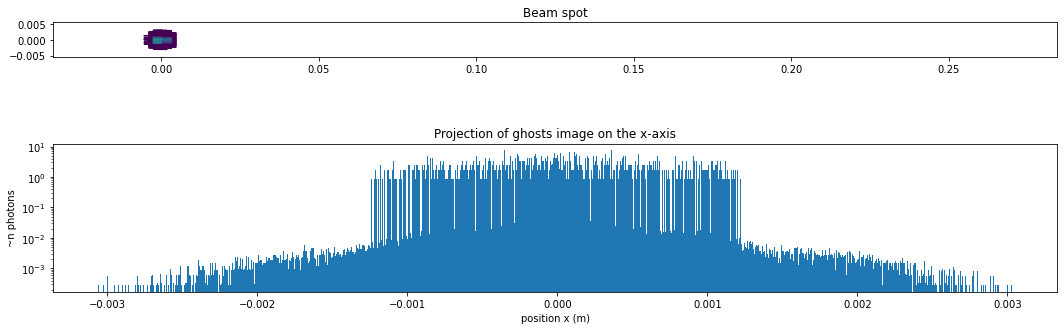

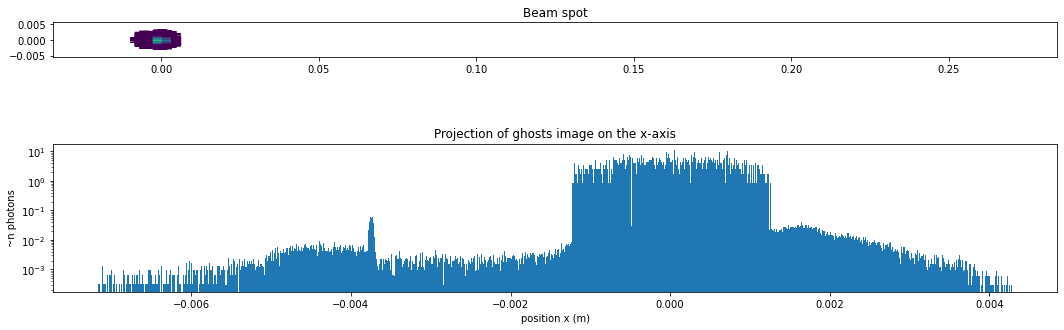

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


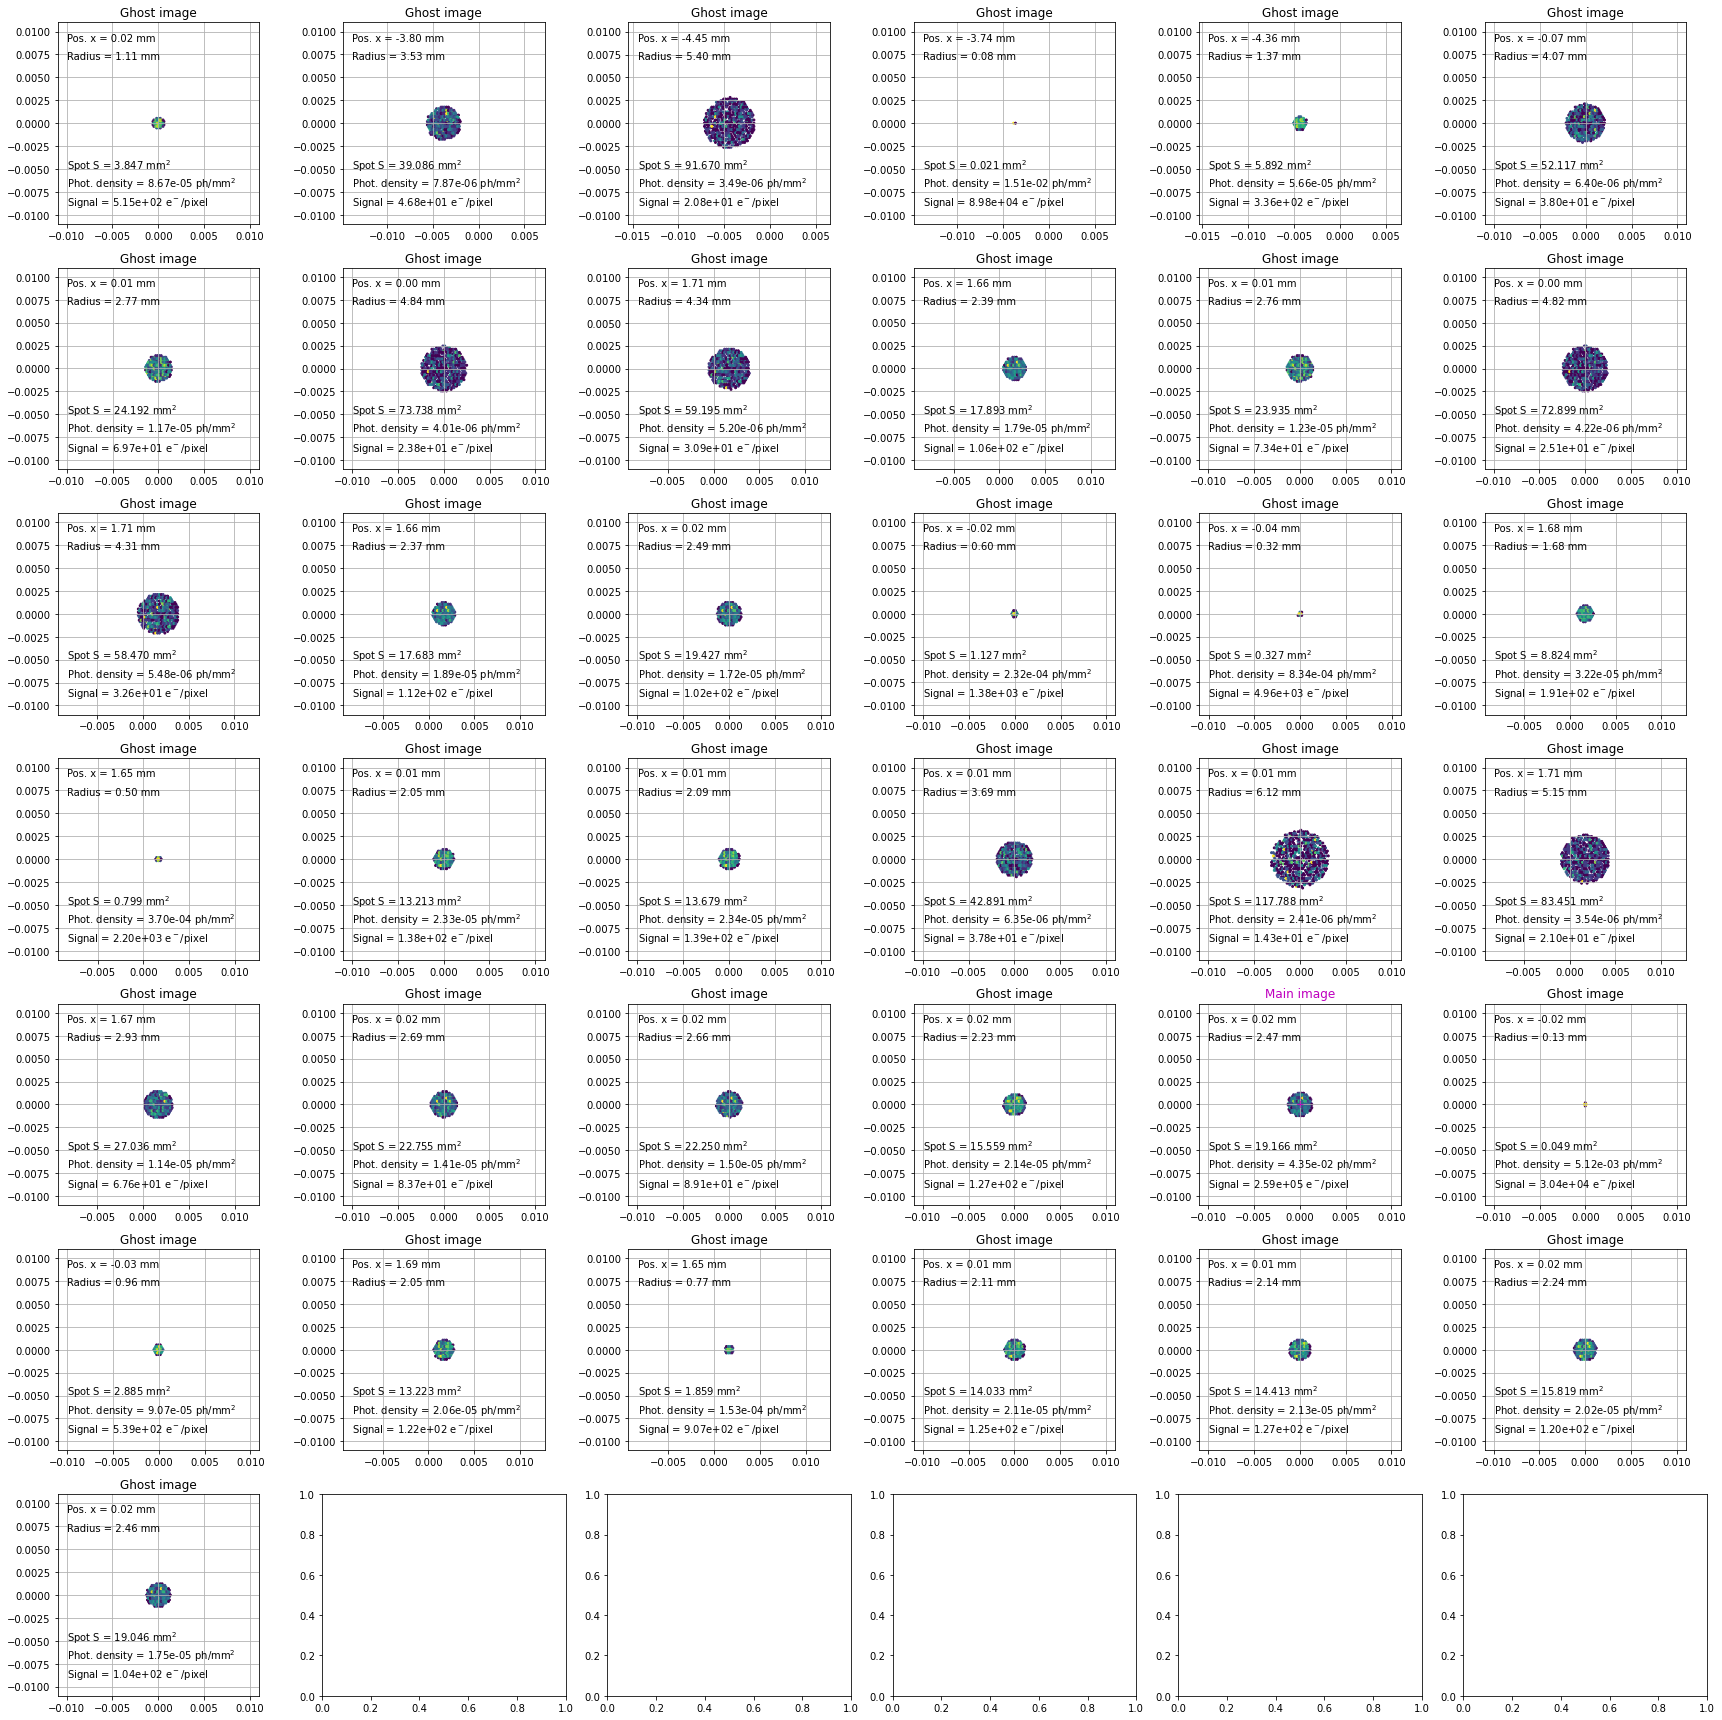

In [26]:
# Rotating L2 around Y
rotated_L2 = tweak_optics.rotate_optic(telescope, 'L2', axis='y', angle=0.1)
tweak_optics.make_optics_reflective(rotated_L2)
traceFull_L2, rForward_L2, rReverse_L2, rays_L2 = simulator.run_simulation(rotated_L2, beam_config=BEAM_CONFIG_0)
plotter.plot_zoom_on_ghosts(rForward)
plotter.plot_zoom_on_ghosts(rForward_L2)
plt.rcParams["figure.figsize"] = [24, 24]
spots_data_L2 = plotter.plot_ghosts_map(rForward_L2)
data_frame_L2 = make_data_frame(spots_data_L2)
ghost_separations_L2 = compute_ghost_separations(data_frame_L2)
plt.show()


L2 rotation of 0.1° means a displacement of 0.523 mm of the lens border.


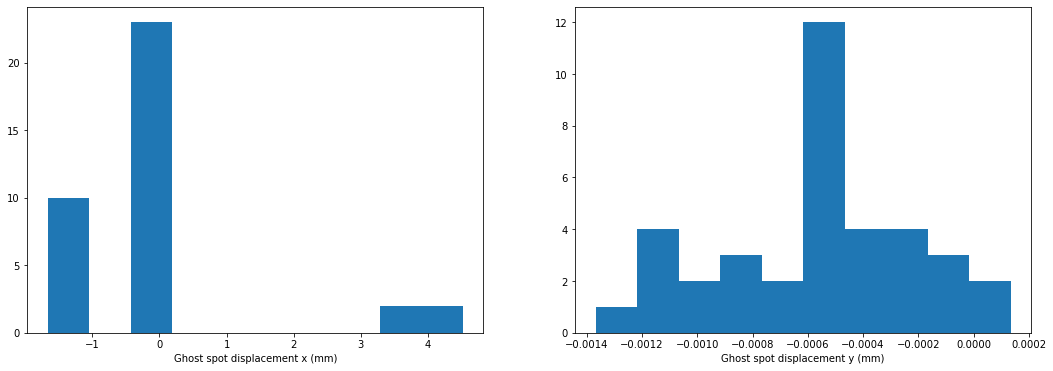

In [27]:
# by how much beam spots moved?
x_diff_L2 = pd.merge(data_frame_1, data_frame_L2, how='left', on='name')
print(f'L2 rotation of 0.1° means a displacement of {300*math.tan(0.1*3.14/180.):.3f} mm of the lens border.')    
plotter.plot_ghosts_displacements(x_diff_L2)
plt.show()


## Rotating L2 by just 0.01°

In [28]:
# now rotating L2 by just 0.01 degrees
df_L2_2, sf_gs_L2_2 = simulator.full_rotation_L2(telescope, angle=0.01)

Max displacement is 24.376 mm for ('L3_exit', 'L1_entrance')


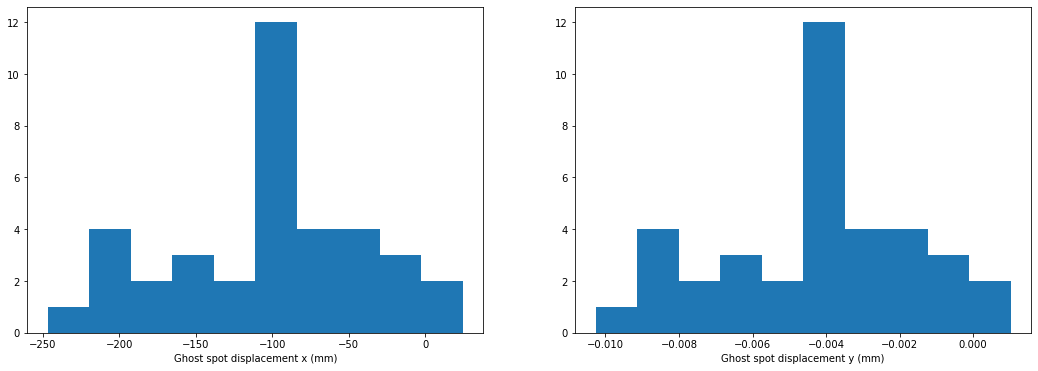

In [29]:
# Merge tables
x_diff_L2_2 = pd.merge(data_frame_1, df_L2_2, how='left', on='name')
# Tmp var
tmp_diff_L2_2 = x_diff_L2_2['pos_x_x']-x_diff_L2_2['pos_x_y']
# Get maximum positive displacement
d_max = max(tmp_diff_L2_2)
i_max = tmp_diff_L2_2.idxmax()
ghost_max = x_diff_L2_2['name'][i_max]
print(f'Max displacement is {d_max*1000:.3f} mm for {ghost_max}')
# Plot
plotter.plot_ghosts_displacements(x_diff_L2_2)
plt.show()


## Scan on L2, Filter, L1 and Camera rotation angles [-1, 1, 0.1]

In [30]:
# Run a scan in L2 rotation
L2_r_merged, L2_angles = simulator.sim_scan_rotated_optic(telescope, 'L2',
                                                          min_angle=-1, max_angle=1, step_angle=0.1,
                                                          ref_data_frame=data_frame_1)

Starting L2 rotation scan.
-1.000 -0.900 -0.800 -0.700 -0.600 -0.500 -0.400 -0.300 -0.200 -0.100 -0.000 0.100 0.200 0.300 0.400 0.500 0.600 0.700 0.800 0.900 Done.


Filter fit results: intercept = -248.670064, slope = 4.864
Filter fit results: intercept = -0.005571, slope = -0.018


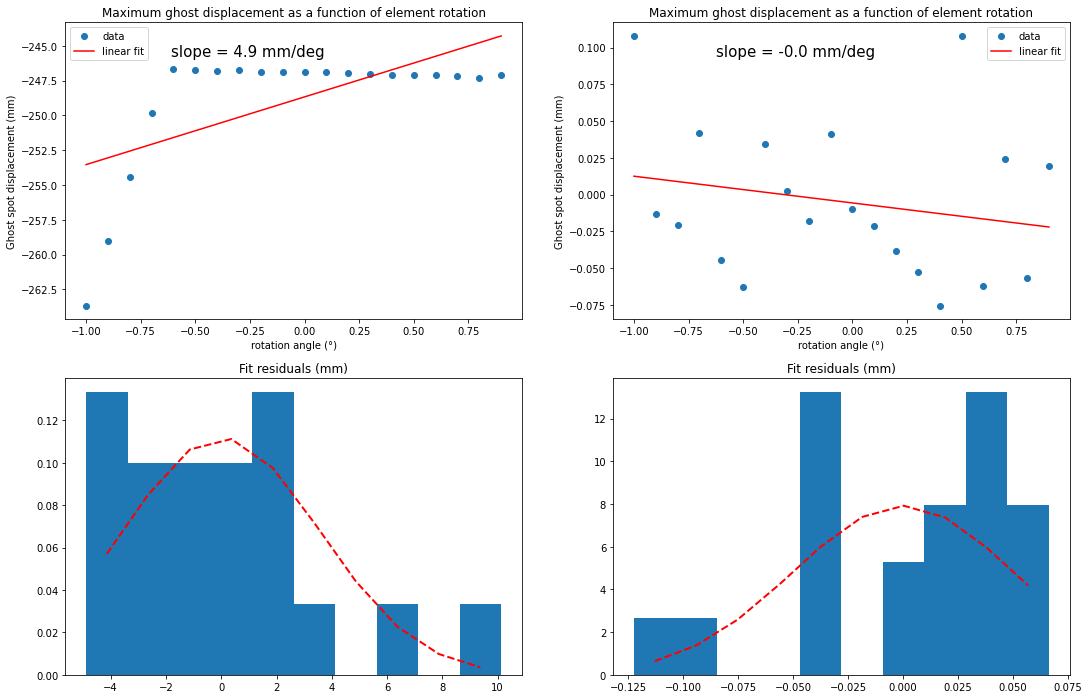

0

In [31]:
# Plot maximum displacement as a function of L2 rotation angle
plotter.plot_max_displacement_for_sim_scan(L2_r_merged, L2_angles)

In [32]:
# Run a scan in Filter rotation
filter_r_merged, filter_angles = simulator.sim_scan_rotated_optic(telescope, 'Filter',
                                                                  min_angle=-1, max_angle=1, step_angle=0.1,
                                                                  ref_data_frame=data_frame_1)

Starting Filter rotation scan.
-1.000 -0.900 -0.800 -0.700 -0.600 -0.500 -0.400 -0.300 -0.200 -0.100 -0.000 0.100 0.200 0.300 0.400 0.500 0.600 0.700 0.800 0.900 Done.


Filter fit results: intercept = -247.232773, slope = 0.975
Filter fit results: intercept = 0.015582, slope = -0.013


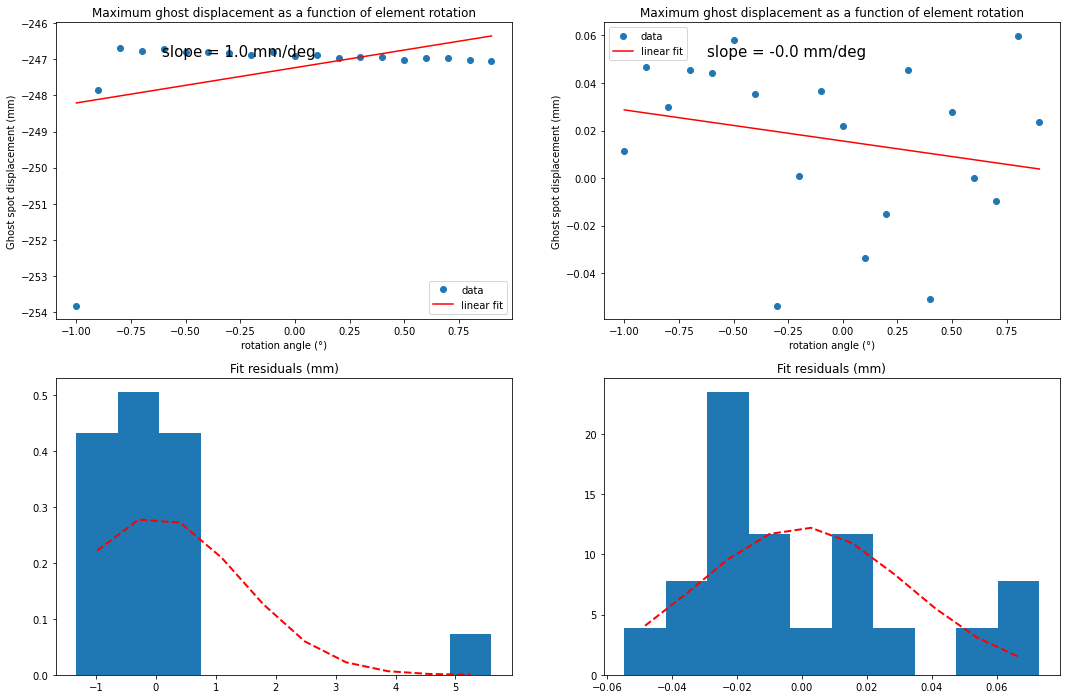

0

In [33]:
# Plot maximum displacement as a function of Filter rotation angle
plotter.plot_max_displacement_for_sim_scan(filter_r_merged, filter_angles)

In [34]:
# Run a scan in L1 rotation
L1_merged, L1_angles = simulator.sim_scan_rotated_optic(telescope, 'L1',
                                                        min_angle=-1, max_angle=1, step_angle=0.1,
                                                        ref_data_frame=data_frame_1)

Starting L1 rotation scan.
-1.000 -0.900 -0.800 -0.700 -0.600 -0.500 -0.400 -0.300 -0.200 -0.100 -0.000 0.100 0.200 0.300 0.400 0.500 0.600 0.700 0.800 0.900 Done.


Filter fit results: intercept = -246.975585, slope = -35.781
Filter fit results: intercept = 0.021014, slope = -0.004


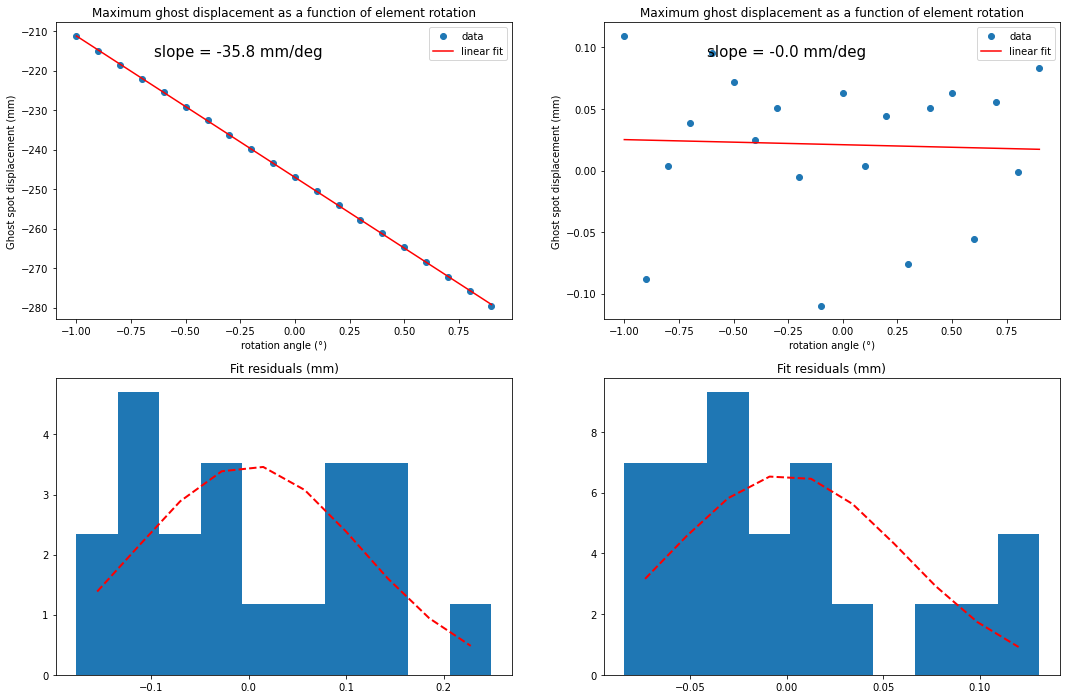

0

In [35]:
# Plot maximum displacement as a function of L1 rotation angle
plotter.plot_max_displacement_for_sim_scan(L1_merged, L1_angles)

In [36]:
# Run a scan in L3 rotation
L3_merged, L3_angles = simulator.sim_scan_rotated_optic(telescope, 'L3',
                                                        min_angle=-1, max_angle=1, step_angle=0.1,
                                                        ref_data_frame=data_frame_1)

Starting L3 rotation scan.
-1.000 -0.900 -0.800 -0.700 -0.600 -0.500 -0.400 -0.300 -0.200 -0.100 -0.000 0.100 0.200 0.300 0.400 0.500 0.600 0.700 0.800 0.900 Done.


Filter fit results: intercept = -250.880725, slope = 52.293
Filter fit results: intercept = 0.004720, slope = 0.015


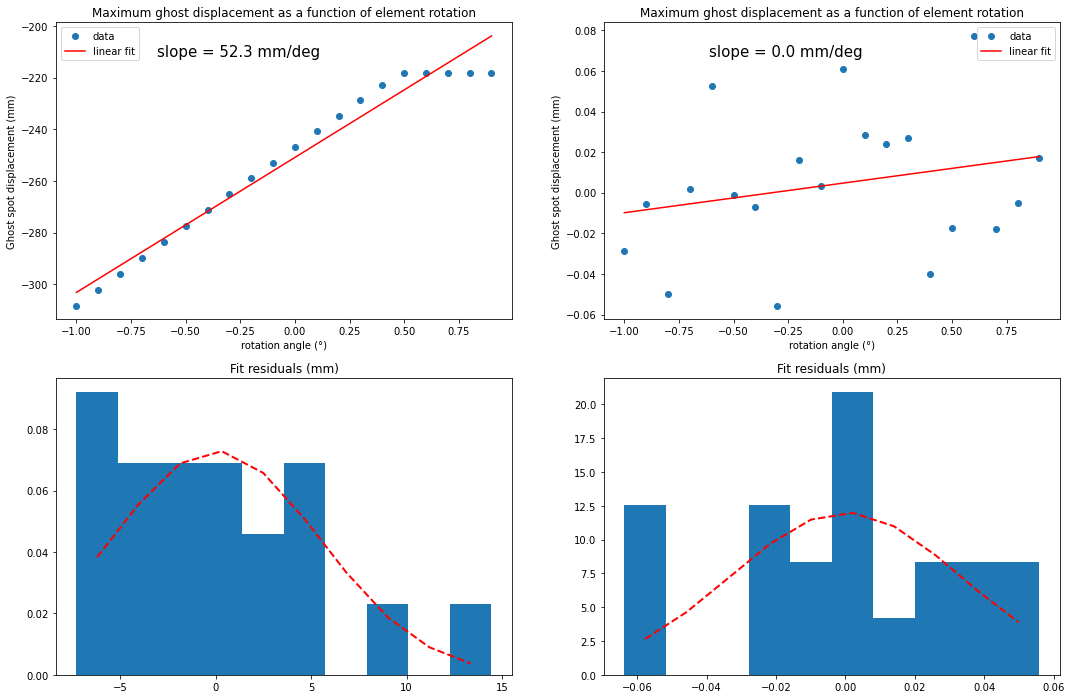

0

In [37]:
# Plot maximum displacement as a function of L3 rotation angle
plotter.plot_max_displacement_for_sim_scan(L3_merged, L3_angles)

In [38]:
# Run a scan in detector rotation
d_merged, d_angles = simulator.sim_scan_rotated_optic(telescope, 'Detector',
                                                      min_angle=-0.1, max_angle=0.1, step_angle=0.005,
                                                      ref_data_frame=data_frame_1)

Starting Detector rotation scan.
-0.100 -0.095 -0.090 -0.085 -0.080 -0.075 -0.070 -0.065 -0.060 -0.055 -0.050 -0.045 -0.040 -0.035 -0.030 -0.025 -0.020 -0.015 -0.010 -0.005 0.000 0.005 0.010 0.015 0.020 0.025 0.030 0.035 0.040 0.045 0.050 0.055 0.060 0.065 0.070 0.075 0.080 0.085 0.090 0.095 Done.


Filter fit results: intercept = -246.886371, slope = 0.194
Filter fit results: intercept = -0.001750, slope = 0.073


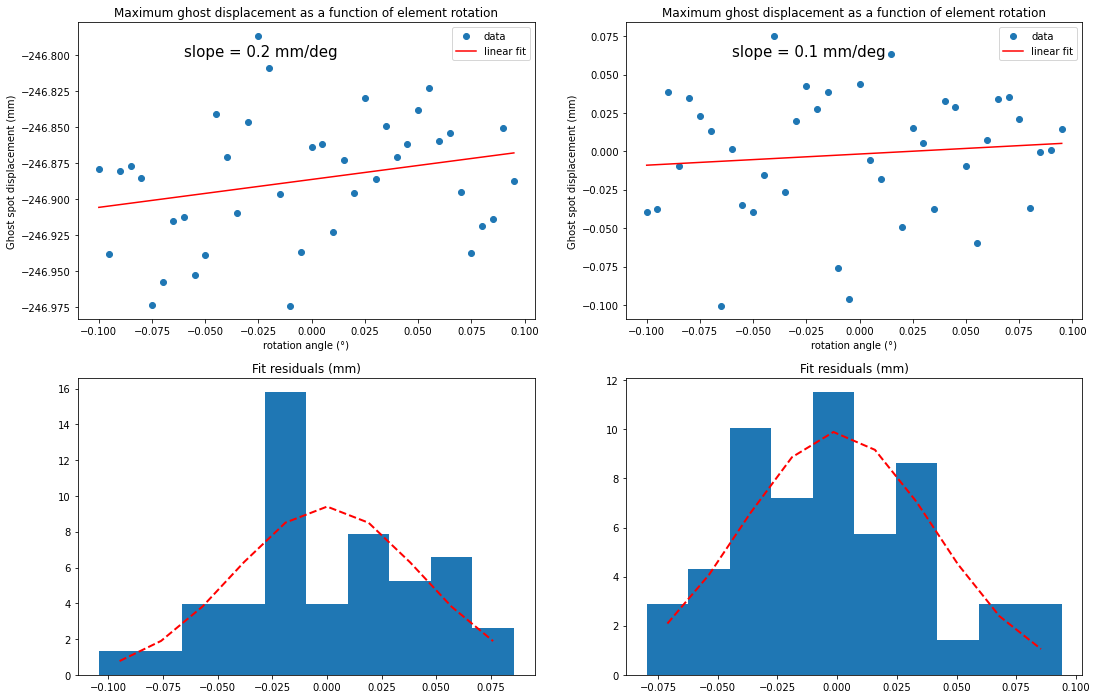

0

In [39]:
# Plot maximum displacement as a function of Detector rotation angle
plotter.plot_max_displacement_for_sim_scan(d_merged, d_angles)

# Now working on Translations


## first test translation

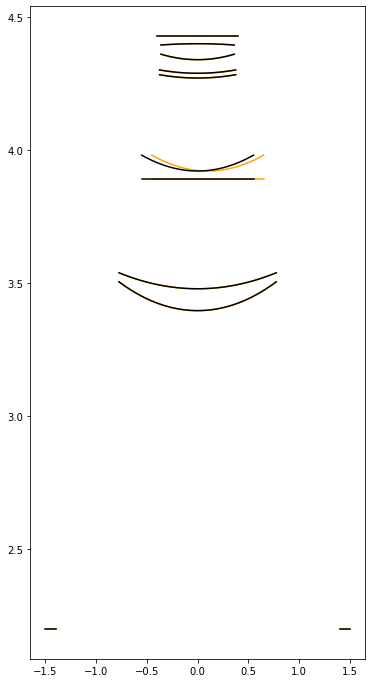

In [40]:
# Moving L2 along X
translated_telescope = tweak_optics.translate_optic(telescope, 'L2', axis='x', distance=0.1)
tweak_optics.make_optics_reflective(translated_telescope)
# showing telescope
fig, ax = plt.subplots(1)
fig.set_size_inches(6, 12)
# after rotation
translated_telescope.draw2d(ax, c='orange')
# before rotation
telescope.draw2d(ax, c='k')
plt.show()

## now check effect on ghost of a 1 cm shift

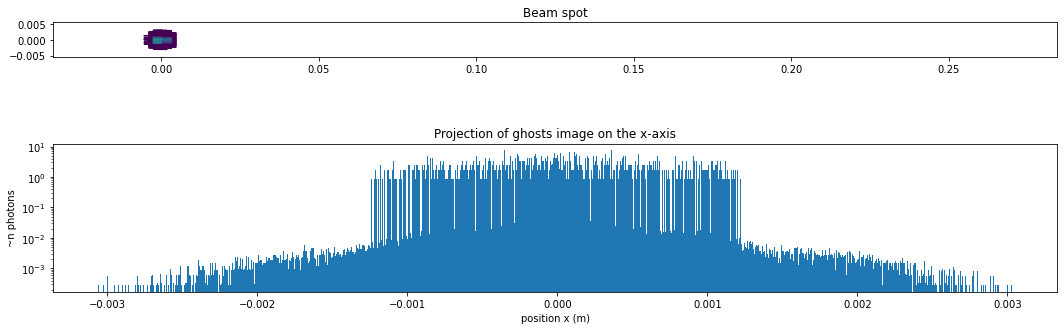

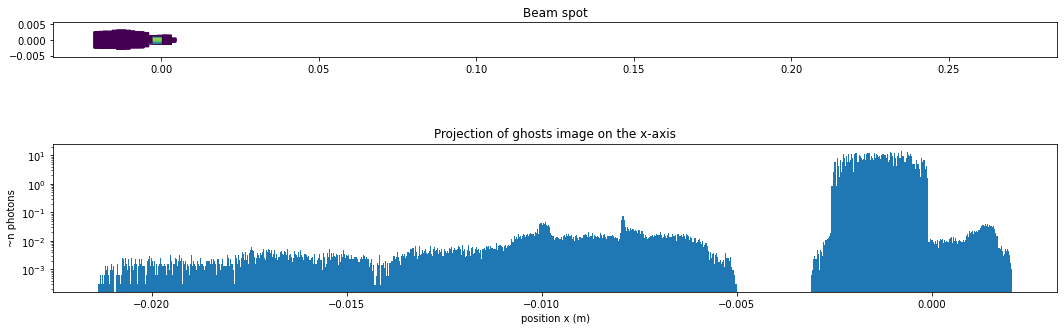

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


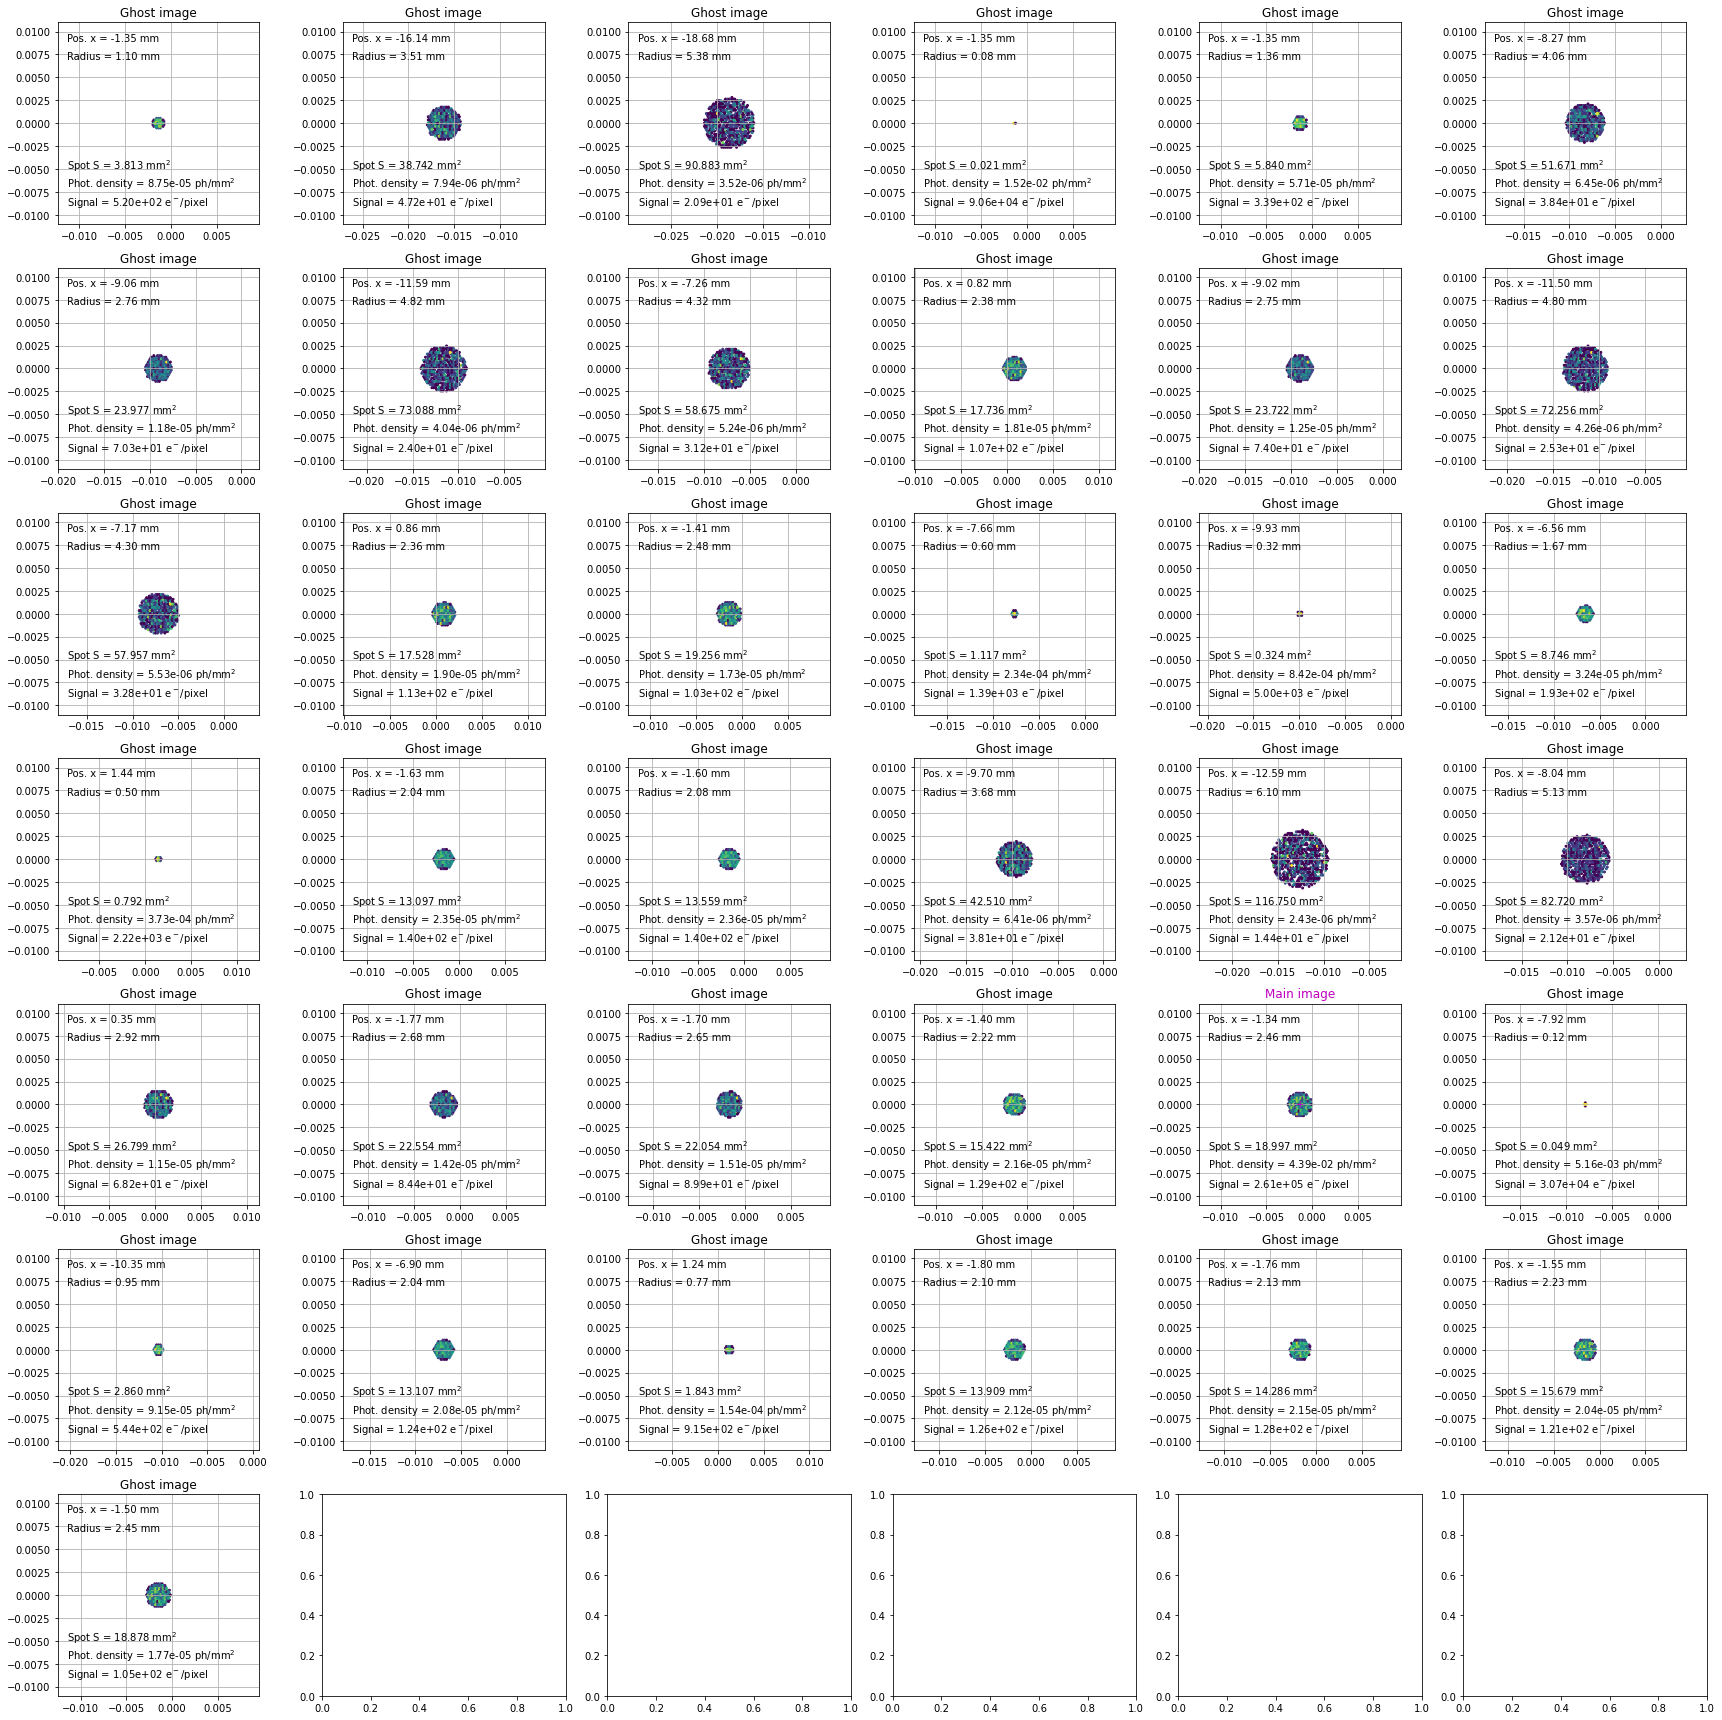

In [41]:
# Rotating L2 around Y
translated_L2 = tweak_optics.translate_optic(telescope, 'L2', axis='x', distance=0.01)
tweak_optics.make_optics_reflective(translated_L2)
traceFull_L2_s, rForward_L2_s, rReverse_L2_s, rays_L2_s = simulator.run_simulation(translated_L2, beam_config=BEAM_CONFIG_0)
plotter.plot_zoom_on_ghosts(rForward)
plotter.plot_zoom_on_ghosts(rForward_L2_s)
plt.rcParams["figure.figsize"] = [24, 24]
spots_data_L2_s = plotter.plot_ghosts_map(rForward_L2_s)
data_frame_L2_s = make_data_frame(spots_data_L2_s)
ghost_separations_L2_s = compute_ghost_separations(data_frame_L2_s)
plt.show()

## now setup a scan in shift of L2

In [42]:
min_dist = -0.01
max_dist = 0.01
step_dist = 0.001
# Scan a shift in L2 along the x axis
L2_shifted, L2_shifts = simulator.sim_scan_translated_optic(telescope, optic_name='L2',
                                                            min_dist=min_dist, max_dist=max_dist, step_dist=step_dist,
                                                            ref_data_frame=data_frame_1)

Starting L2 translation scan.
-0.010000 -0.009000 -0.008000 -0.007000 -0.006000 -0.005000 -0.004000 -0.003000 -0.002000 -0.001000 -0.000000 0.001000 0.002000 0.003000 0.004000 0.005000 0.006000 0.007000 0.008000 0.009000 Done.


Filter fit results: intercept = -246.877288, slope = 1263.692
Filter fit results: intercept = 0.013771, slope = 5.420


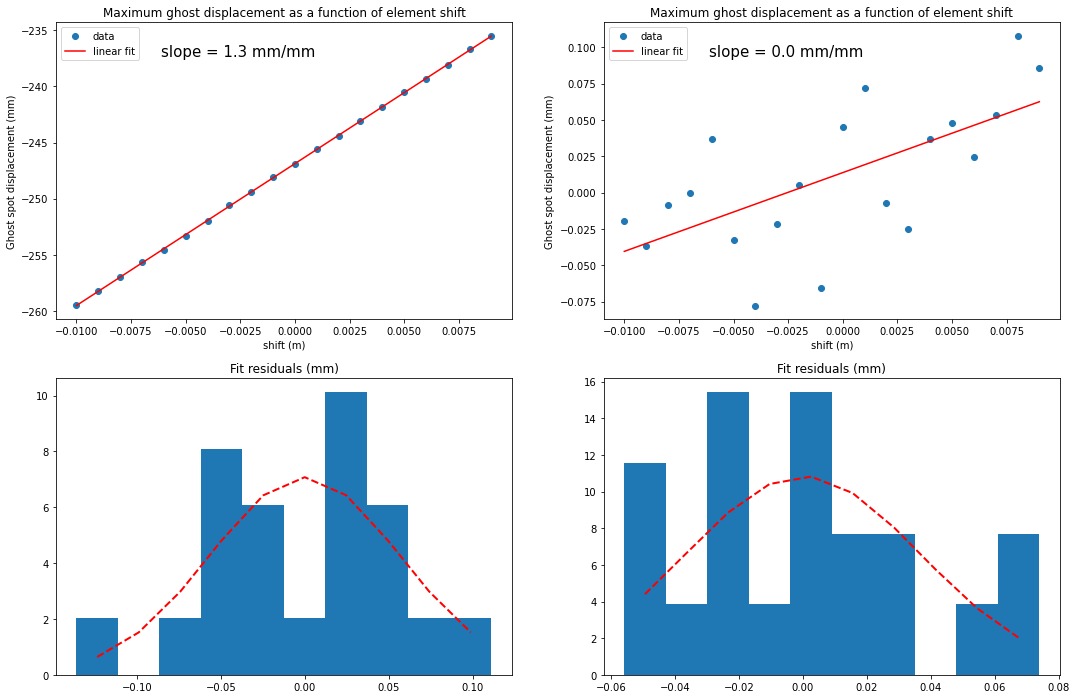

0

In [43]:
# plot max ghost spot displacement
plotter.plot_max_displacement_for_sim_scan(L2_shifted, L2_shifts, trans_type='shift')

## shift filter


In [44]:
# Scan a shift in L2 along the x axis
f_shifted, f_shifts = simulator.sim_scan_translated_optic(telescope, optic_name='Filter',
                                                          min_dist=min_dist, max_dist=max_dist, step_dist=step_dist,
                                                          ref_data_frame=data_frame_1)

Starting Filter translation scan.
-0.010000 -0.009000 -0.008000 -0.007000 -0.006000 -0.005000 -0.004000 -0.003000 -0.002000 -0.001000 -0.000000 0.001000 0.002000 0.003000 0.004000 0.005000 0.006000 0.007000 0.008000 0.009000 Done.


Filter fit results: intercept = -246.895282, slope = -2.705
Filter fit results: intercept = 0.011648, slope = -0.854


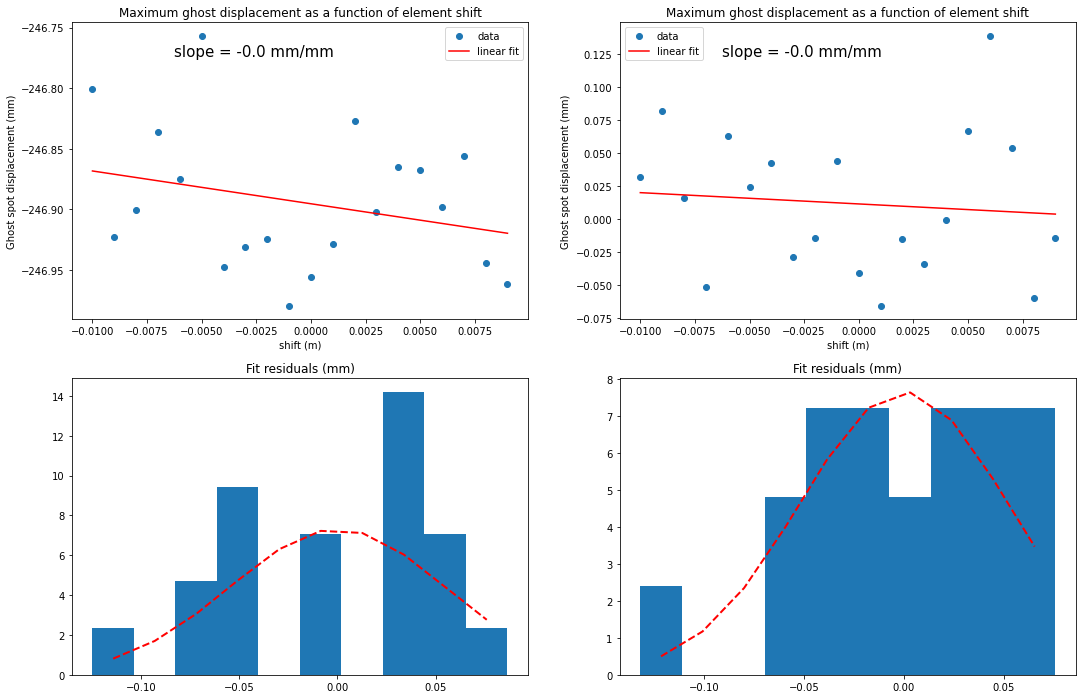

0

In [45]:
# plot max ghost spot displacement
plotter.plot_max_displacement_for_sim_scan(f_shifted, f_shifts, trans_type='shift')

## look at a more realistic shift of the detector plane

In [46]:
# Scan a shift in L2 along the x axis
d_shifted, d_shifts = simulator.sim_scan_translated_optic(telescope, optic_name='Detector',
                                                          min_dist=-0.0005, max_dist=0.0005, step_dist=0.00001,
                                                          ref_data_frame=data_frame_1)

Starting Detector translation scan.
-0.000500 -0.000490 -0.000480 -0.000470 -0.000460 -0.000450 -0.000440 -0.000430 -0.000420 -0.000410 -0.000400 -0.000390 -0.000380 -0.000370 -0.000360 -0.000350 -0.000340 -0.000330 -0.000320 -0.000310 -0.000300 -0.000290 -0.000280 -0.000270 -0.000260 -0.000250 -0.000240 -0.000230 -0.000220 -0.000210 -0.000200 -0.000190 -0.000180 -0.000170 -0.000160 -0.000150 -0.000140 -0.000130 -0.000120 -0.000110 -0.000100 -0.000090 -0.000080 -0.000070 -0.000060 -0.000050 -0.000040 -0.000030 -0.000020 -0.000010 0.000000 0.000010 0.000020 0.000030 0.000040 0.000050 0.000060 0.000070 0.000080 0.000090 0.000100 0.000110 0.000120 0.000130 0.000140 0.000150 0.000160 0.000170 0.000180 0.000190 0.000200 0.000210 0.000220 0.000230 0.000240 0.000250 0.000260 0.000270 0.000280 0.000290 0.000300 0.000310 0.000320 0.000330 0.000340 0.000350 0.000360 0.000370 0.000380 0.000390 0.000400 0.000410 0.000420 0.000430 0.000440 0.000450 0.000460 0.000470 0.000480 0.000490 Done.


Filter fit results: intercept = -246.882495, slope = 987.225
Filter fit results: intercept = 0.008635, slope = -13.573


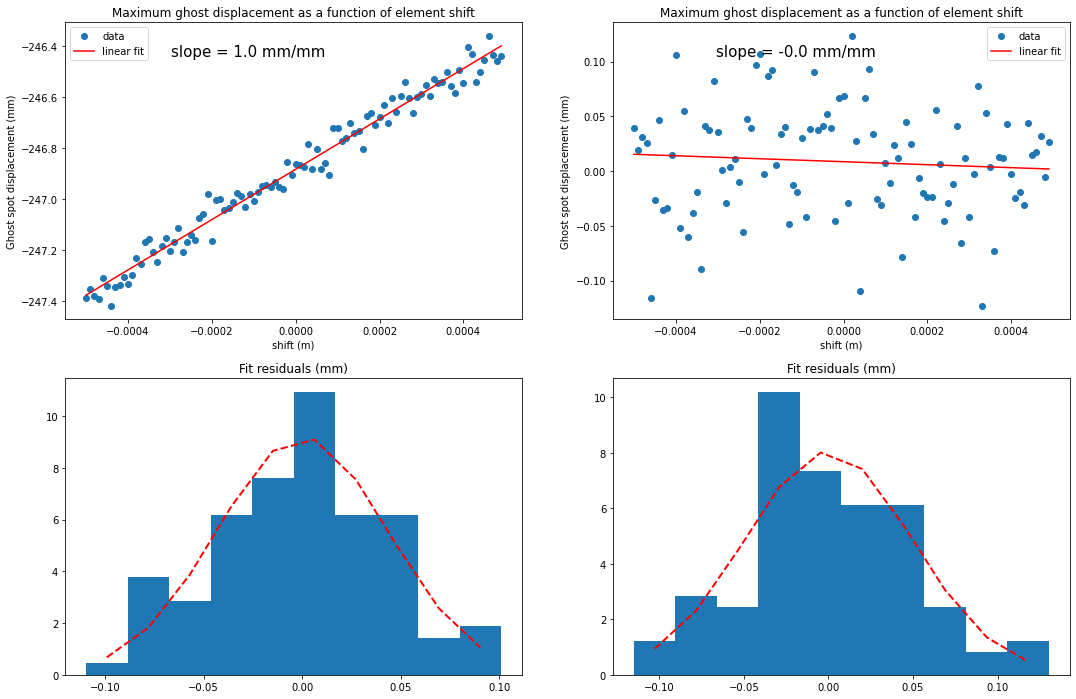

0

In [47]:
# plot max ghost spot displacement
plotter.plot_max_displacement_for_sim_scan(d_shifted, d_shifts, trans_type='shift')

# Now building telescopes with randomly translated and rotated optics

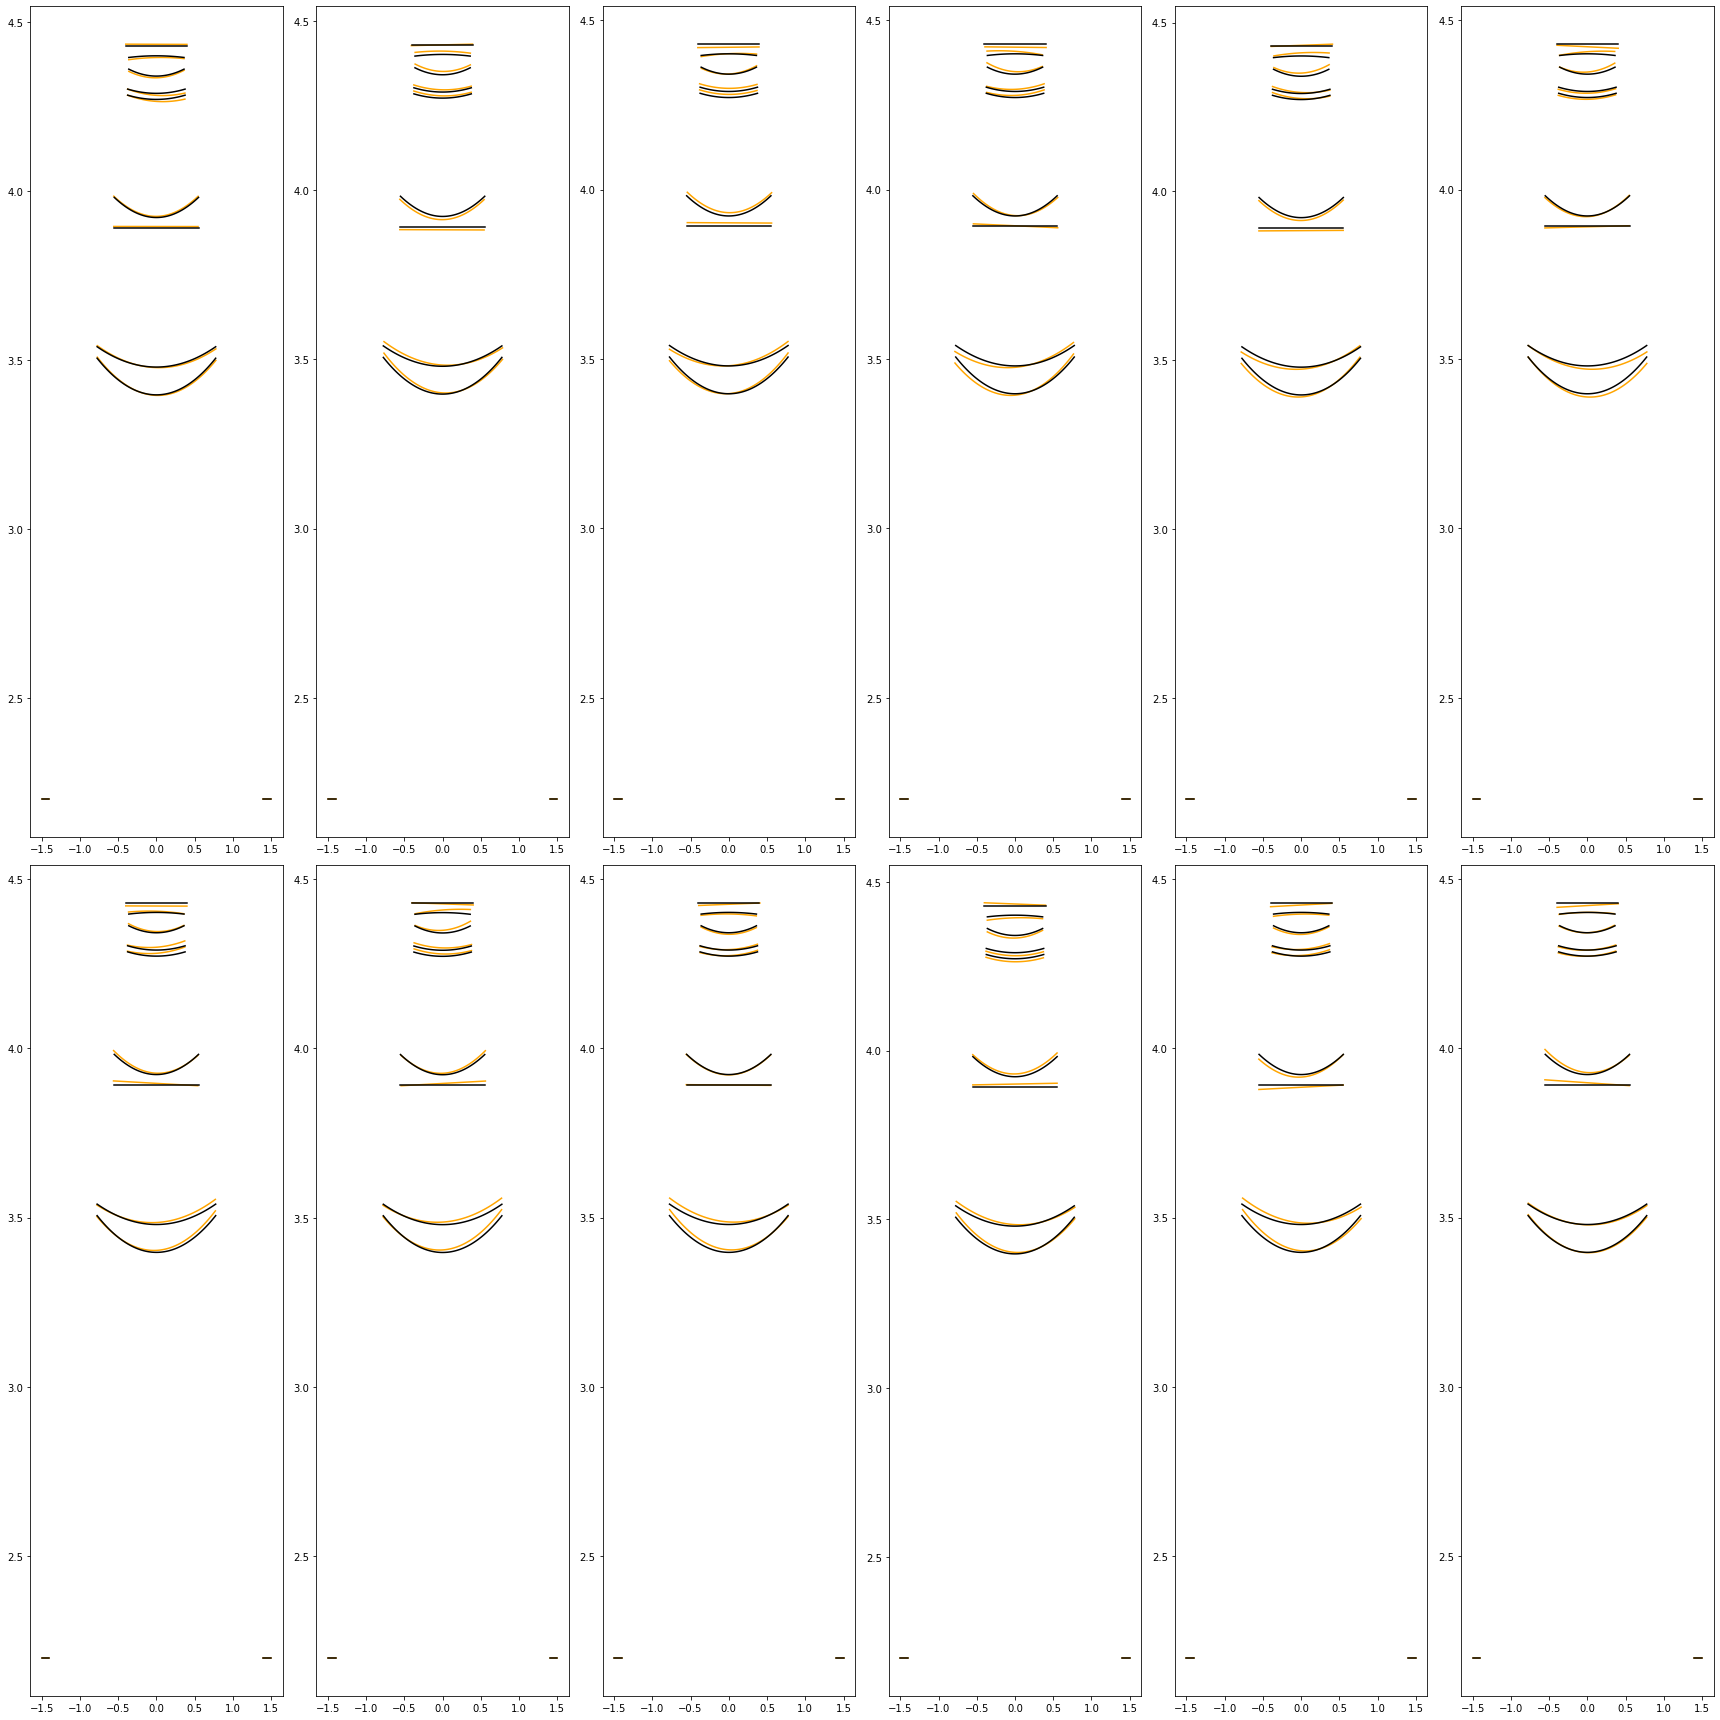

In [48]:
# showing telescopes
fig, ax = plt.subplots(2, 6)
fig.set_size_inches(24, 24)
ax = ax.flatten()
# draw plenty of random telescopes
for i in range(12):
    rnd_tel = tweak_optics.randomized_telescope(telescope, max_angle=1, max_shift=0.01)
    tweak_optics.make_optics_reflective(rnd_tel)
    rnd_tel.draw2d(ax[i], c='orange')
    # before rotation
    telescope.draw2d(ax[i], c='k')
plt.tight_layout()
plt.show()

# Characterize impact of randomizing telescope on an on the optical axis light beam


In [49]:
# Create new beam config with less photons to be simulated
BEAM_CONFIG_on_axis_fast = copy.copy(BEAM_CONFIG_0)
BEAM_CONFIG_on_axis_fast['n_photons'] = 100


In [50]:
# Check main spot position for multiple different random telescopes
main_spot_name = ('main', 'main')
def get_spot_x():
    df, gh = simulator.full_random_telescope_sim(telescope, max_angle=0.1, max_shift=0.001,
                                                 beam_config=BEAM_CONFIG_on_axis_fast)
    return df[df['name']==main_spot_name]['pos_x'].item()

x_spot_future = list()

starttime = timeit.default_timer()
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(get_spot_x, ) for i in range(10)]
    for future in concurrent.futures.as_completed(futures):
        x_spot_future.append(future.result())
stoptime = timeit.default_timer()

print(x_spot_future)
print("The time difference is :", stoptime - starttime)


[-0.0006445022650076851, -0.0005776631936065214, -0.0011101794326169557, 0.0005656615594759024, -0.0004430835828970317, -0.00032614195906524097, 3.9947680130822405e-05, 0.000813703011536199, 0.0003092244673851937, 0.0009098613758339798]
The time difference is : 17.980826280021574


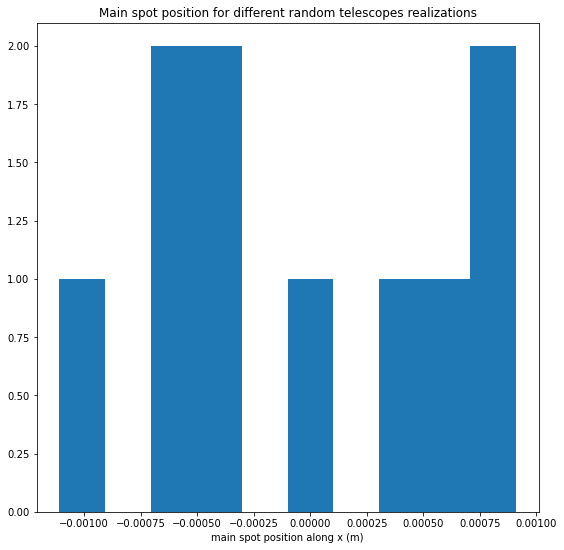

In [51]:
# plot position of the main spot for all random telescopes
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 9)
ax.hist(x_spot_future)
ax.set_title('Main spot position for different random telescopes realizations')
ax.set_xlabel('main spot position along x (m)')
plt.show()